# **Forecasting Stock Volatility:**

**Topic:**
Can we use deep neural network to forecast the stock return volatility? Which model provides the best forcasting performance?

**Data:**
In computer lab_3_1, we show the method to download stock prices from Yahoo Finance. This topic uses the stock adjusted prices to calculate its volatility (use the standard deviation of the past 30-day arithmetic return as the volatility).

**Method:**
The features include the downloaded five columns of Open, High, Low, Close, and Adj Close and the calculated arithmetic return and current volatility. We may model the seven features as multi-dimensional time series to forecast the future volatility over 𝐻 future horizons (𝐻 ≥ 1).
The features can be defined as a vector
𝐗 = (𝑂 ,𝐻 ,𝐿 ,𝐶𝑙𝑜𝑠𝑒 ,𝐴𝑑𝑗𝐶𝑙𝑜𝑠𝑒 ,𝑟 ,𝑉𝑂𝐿 )𝑇 

This project is to estimate the function 𝑓(∙), that takes a sequence of historical 𝐗𝑡 as input and generates vector 𝐕𝐎𝐋𝑡 = (𝐕𝐎𝐋𝑡,1, ... , 𝐕𝐎𝐋𝑡,𝐻)𝑇 as output:

𝐕𝐎𝐋𝑡 =𝑓(𝐗𝑡,𝐗𝑡−1,𝐗𝑡−2,...,𝐗𝑡−𝑾) 
Where 𝑾 is the look back window, 𝑗 = 1,...,𝐻.

This topic shall use LSTM as one of the potential models. You may try to train the LSTM model with the raw 7-dimension features 𝐗𝑡 with different 𝑾. You may also extract the features with lower dimensions 𝑀 < 7 by autoencoder and then train the LSTM model using the extracted features with different 𝑾. You can provide a comparison of those two methods.
This topic may also answer what look back window 𝑾 and horizon 𝐻 generate the best forecasting results.

## Importing Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from tensorflow.python import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from google.colab import drive

import warnings
warnings.filterwarnings("ignore")

## Getting the data

In [2]:
#Define the stock Start and End Date 
start = pd.to_datetime('19970101',format='%Y%m%d')
end = pd.to_datetime('20230311',format='%Y%m%d')
days = (end-start).days
print('total days: ', days)

total days:  9565


In [3]:
drive.mount('/drive', force_remount=True)

df = pd.read_csv('/drive/My Drive/Colab Notebooks/nasdaq_listed.csv')
df

Mounted at /drive


,Symbol,Company Name,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size
0,AAIT,iShares MSCI All Country Asia Information Tech...,iShares MSCI All Country Asia Information Tech...,G,N,N,100
1,AAL,"American Airlines Group, Inc.","American Airlines Group, Inc. - Common Stock",Q,N,N,100
2,AAME,Atlantic American Corporation,Atlantic American Corporation - Common Stock,G,N,N,100
3,AAOI,"Applied Optoelectronics, Inc.","Applied Optoelectronics, Inc. - Common Stock",G,N,N,100
4,AAON,"AAON, Inc.","AAON, Inc. - Common Stock",Q,N,N,100
...,...,...,...,...,...,...,...
2962,ZN,Zion Oil & Gas Inc,Zion Oil & Gas Inc - Common Stock,G,N,N,100
2963,ZNGA,Zynga Inc.,Zynga Inc. - Class A Common Stock,Q,N,N,100
2964,ZSPH,"ZS Pharma, Inc.","ZS Pharma, Inc. - Common Stock",G,N,N,100
2965,ZU,"zulily, inc.","zulily, inc. - Class A Common Stock",Q,N,N,100


In [4]:
#printing the details of the target company for getting its ticker
df[df['Company Name']=='Apple Inc.']

,Symbol,Company Name,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size
5,AAPL,Apple Inc.,Apple Inc. - Common Stock,Q,N,N,100


In [5]:
stock = yf.download('AAPL', start=start, end=end, progress=False)

# create empty dataframe
stock_final = pd.DataFrame()
stock_final = stock_final.append(stock,sort=False)
stock_final

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-01-02,0.188616,0.189732,0.185268,0.187500,0.159585,143113600
1997-01-03,0.188616,0.198661,0.187500,0.194196,0.165284,119716800
1997-01-06,0.157366,0.163783,0.154018,0.159598,0.135837,1882832000
1997-01-07,0.161830,0.162946,0.156250,0.156250,0.132987,976931200
1997-01-08,0.162946,0.164063,0.155134,0.157366,0.133937,1100131200
...,...,...,...,...,...,...
2023-03-06,153.789993,156.300003,153.460007,153.830002,153.830002,87558000
2023-03-07,153.699997,154.029999,151.130005,151.600006,151.600006,56182000
2023-03-08,152.809998,153.470001,151.830002,152.869995,152.869995,47204800


In [6]:
stock_final['return'] = np.log(stock_final['Adj Close']) - np.log(stock_final['Adj Close'].shift(1))
stock_final

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
1997-01-02,0.188616,0.189732,0.185268,0.187500,0.159585,143113600,NaN
1997-01-03,0.188616,0.198661,0.187500,0.194196,0.165284,119716800,0.035089
1997-01-06,0.157366,0.163783,0.154018,0.159598,0.135837,1882832000,-0.196210
1997-01-07,0.161830,0.162946,0.156250,0.156250,0.132987,976931200,-0.021201
1997-01-08,0.162946,0.164063,0.155134,0.157366,0.133937,1100131200,0.007117
...,...,...,...,...,...,...,...
2023-03-06,153.789993,156.300003,153.460007,153.830002,153.830002,87558000,0.018370
2023-03-07,153.699997,154.029999,151.130005,151.600006,151.600006,56182000,-0.014603
2023-03-08,152.809998,153.470001,151.830002,152.869995,152.869995,47204800,0.008342


In [7]:
#calculating the volatility using the 30 day artihmetic returns
stock_final['volatility'] = stock_final['return'].rolling(window=30).std()
stock_final = stock_final.dropna()
stock_final

,Open,High,Low,Close,Adj Close,Volume,return,volatility
Date,,,,,,,,
1997-02-13,0.140625,0.143973,0.138393,0.143973,0.122538,195832000,0.023529,0.041315
1997-02-14,0.145089,0.146205,0.142857,0.145647,0.123963,237249600,0.011560,0.040671
1997-02-18,0.148438,0.159598,0.145089,0.159598,0.135837,368278400,0.091472,0.026651
1997-02-19,0.159598,0.159598,0.152902,0.157366,0.133937,241292800,-0.014084,0.026487
1997-02-20,0.157366,0.157366,0.151786,0.151786,0.129188,124947200,-0.036102,0.027263
...,...,...,...,...,...,...,...,...
2023-03-06,153.789993,156.300003,153.460007,153.830002,153.830002,87558000,0.018370,0.016406
2023-03-07,153.699997,154.029999,151.130005,151.600006,151.600006,56182000,-0.014603,0.016307
2023-03-08,152.809998,153.470001,151.830002,152.869995,152.869995,47204800,0.008342,0.016283


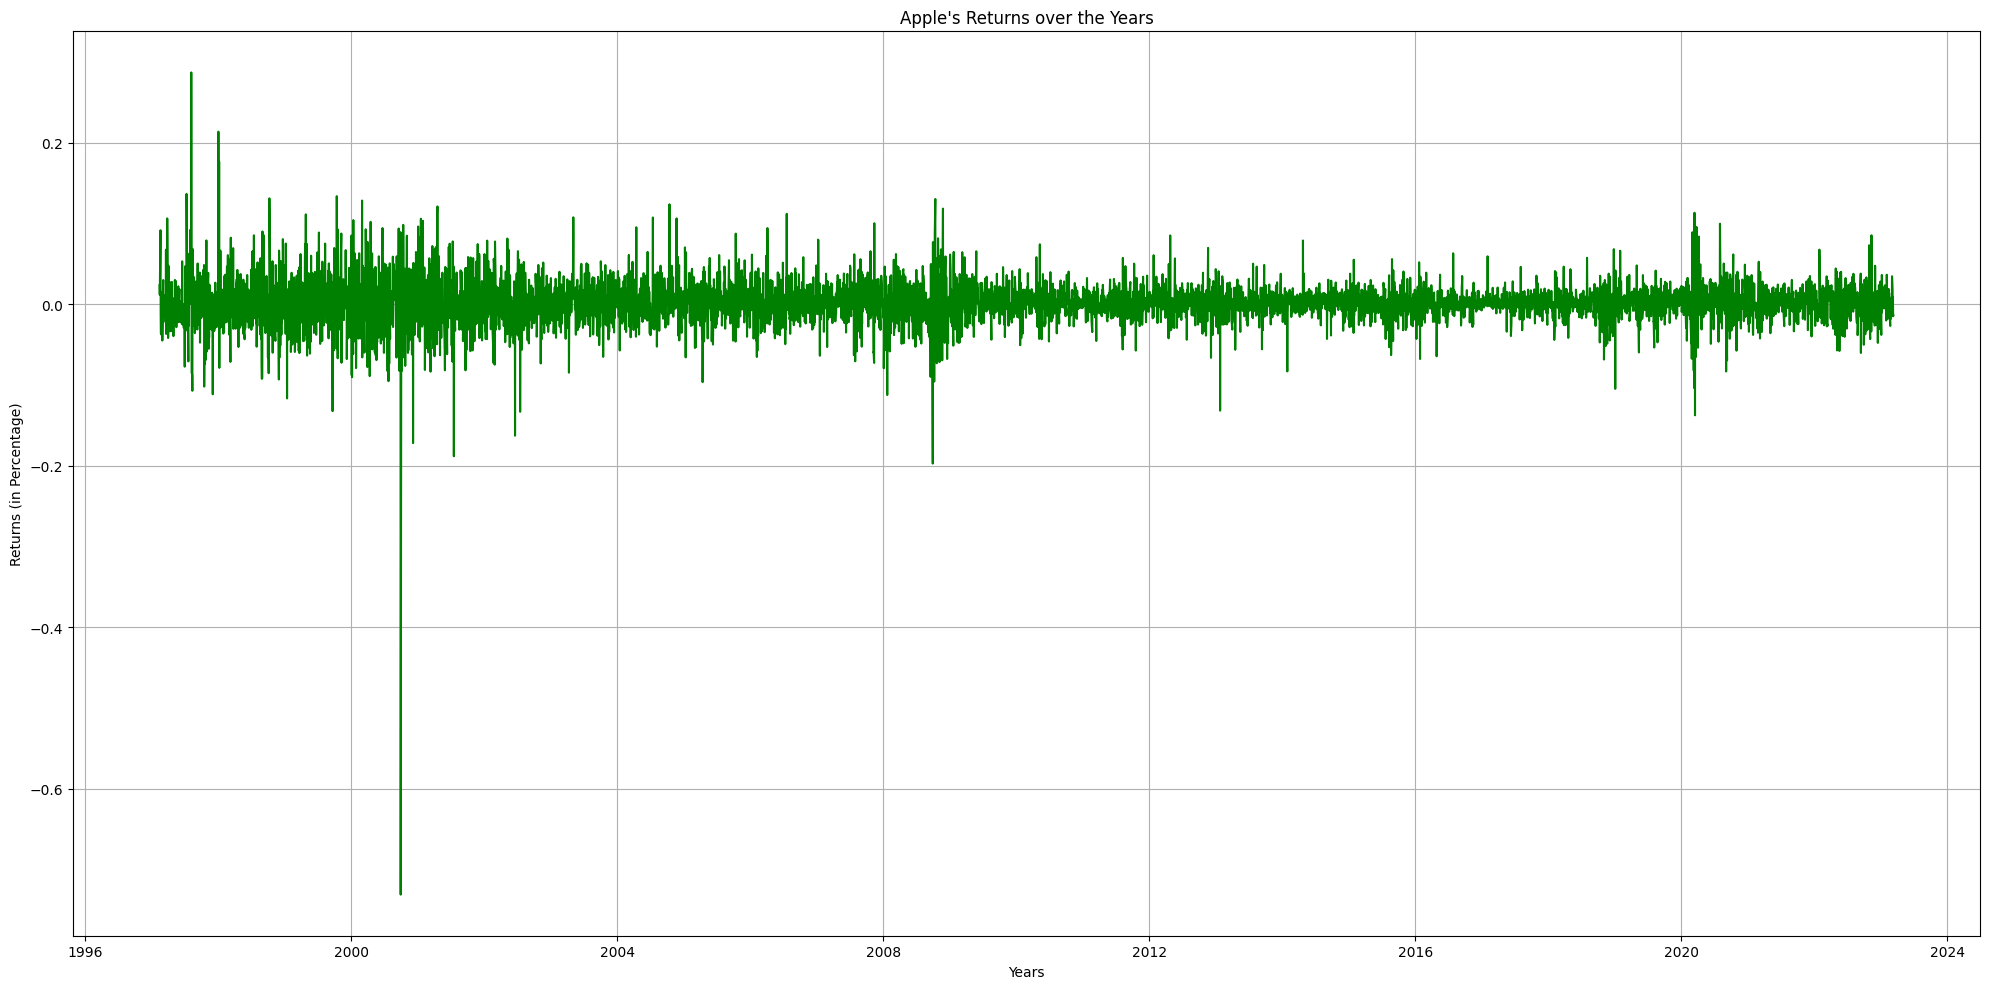

In [8]:
#plotting the stock returns 
plt.figure(figsize=(20,10))
plt.plot(stock_final.index, stock_final['return'], 'g-')
plt.title(f'Apple\'s Returns over the Years')
plt.xlabel('Years')
plt.ylabel('Returns (in Percentage)')
plt.grid()
plt.tight_layout()
plt.show()

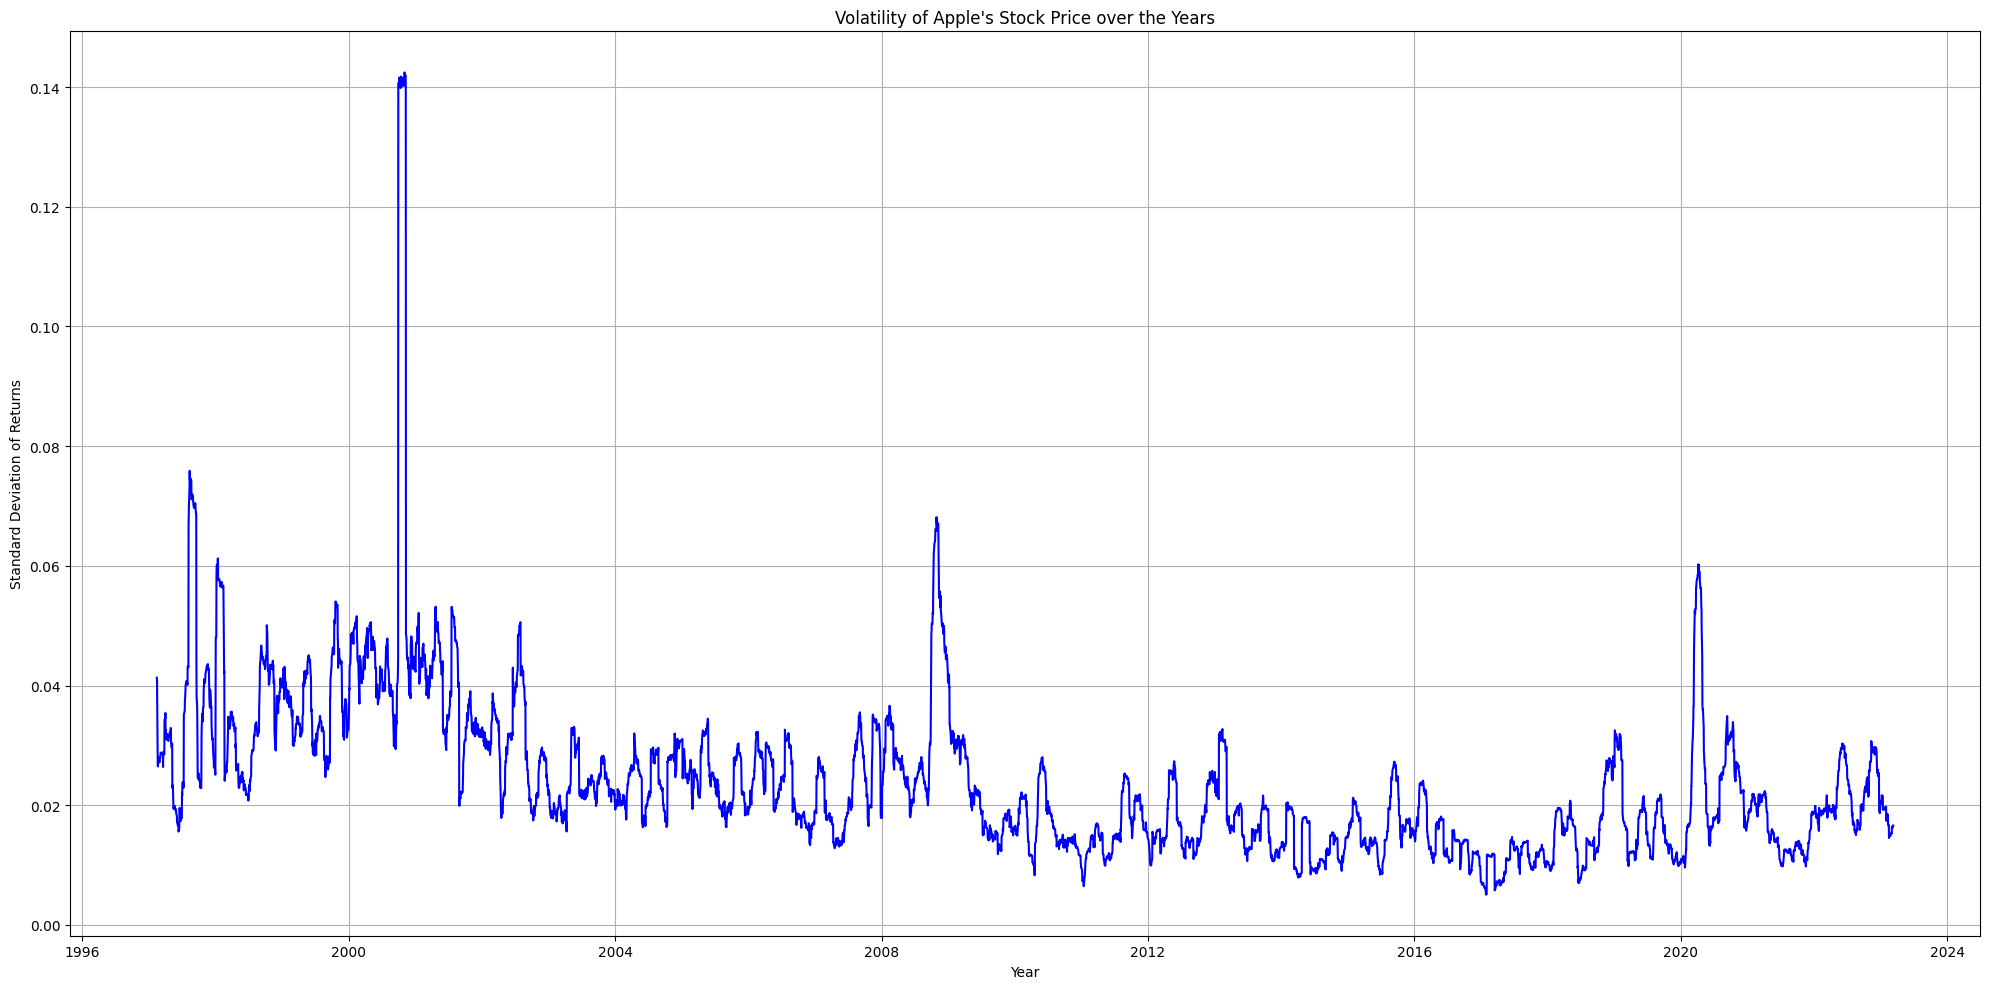

In [9]:
#plottong stock price volatility
plt.figure(figsize=(20,10))
plt.plot(stock_final.index, stock_final['volatility'], 'b-')
plt.title(f'Volatility of Apple\'s Stock Price over the Years')
plt.xlabel('Year')
plt.ylabel('Standard Deviation of Returns')
plt.grid()
plt.tight_layout()
plt.show()

## Defining X and Y

In [10]:
#Defining X and y
X = stock_final[['Open', 'High', 'Low', 'Close', 'Adj Close', 
                 'return', 'volatility']].values
y = stock_final[['volatility']].values

#printing the shape of X and y
print('X: ', X.shape)
print('Y: ', y.shape)

X:  (6561, 7)
Y:  (6561, 1)


## LSTM with Cross Validation

In [11]:
#Defining the look-back window and forecast horizon
W = 1
H = 1

#creating an object of TimeSeriesSplit
rows, cols = X.shape
train_window = 500
test_window = 500
n_windows = int( (rows-train_window)/test_window )
tscv = TimeSeriesSplit(n_splits=n_windows, 
    max_train_size=train_window, 
    test_size=test_window, )
print('Number of folds :{}'.format(n_windows))

Number of folds :12


In [12]:
#defining the structure of LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(W, 7), return_sequences=True)) 
model.add(LSTM(32))
model.add(Dense(H))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
                loss='mse', metrics=['mae'])

#displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


4/4 [==============================] - 1s 8ms/step - loss: 1.6125e-04 - mae: 0.0081


<Figure size 3000x1000 with 0 Axes>

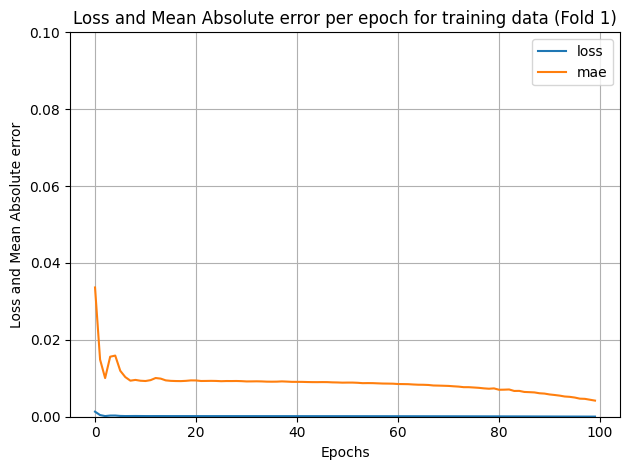

4/4 [==============================] - 1s 4ms/step


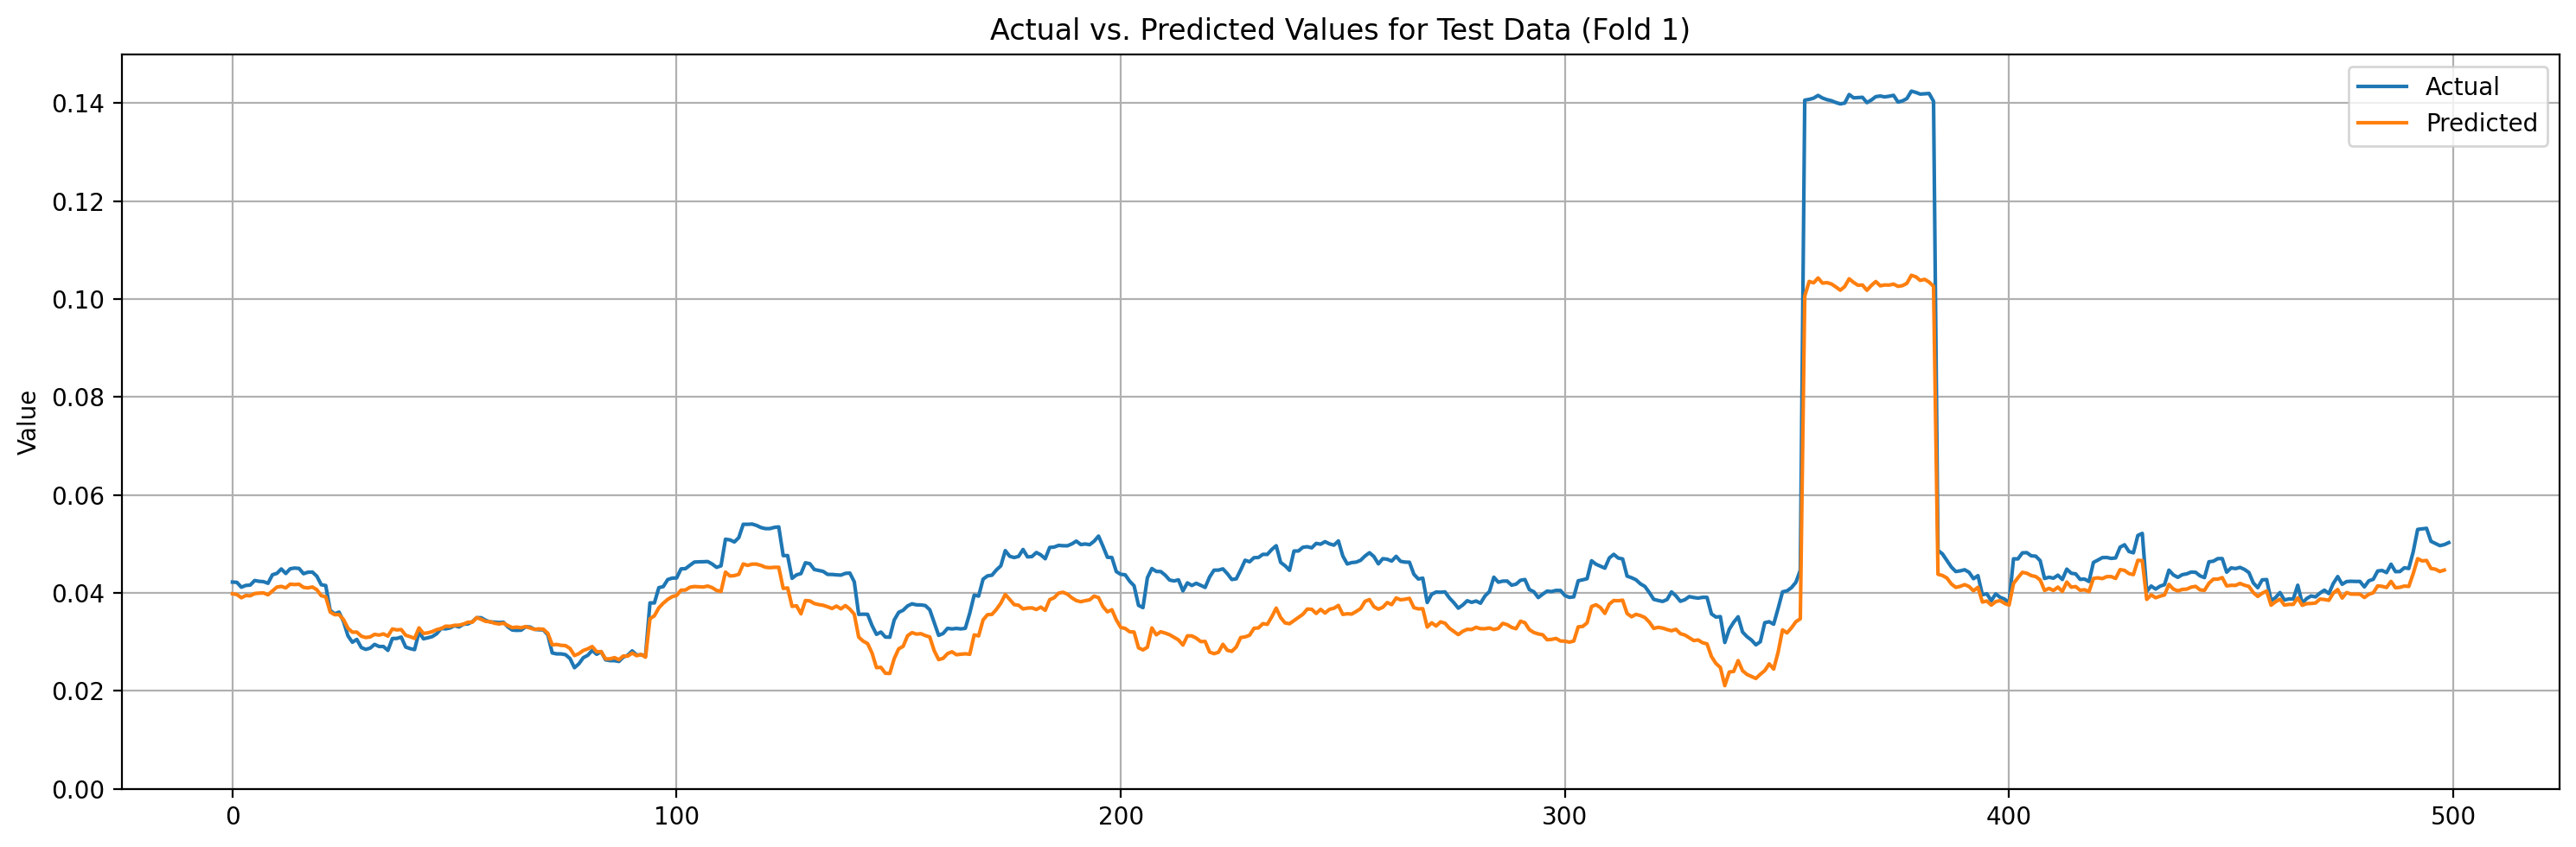

4/4 [==============================] - 0s 6ms/step - loss: 3.3054e-06 - mae: 0.0011


<Figure size 3000x1000 with 0 Axes>

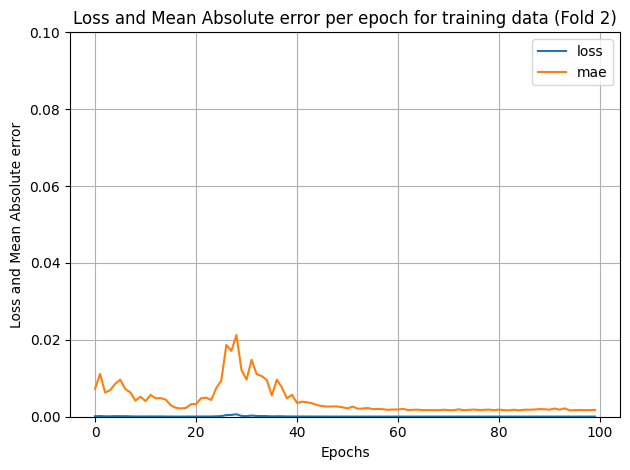

4/4 [==============================] - 0s 5ms/step


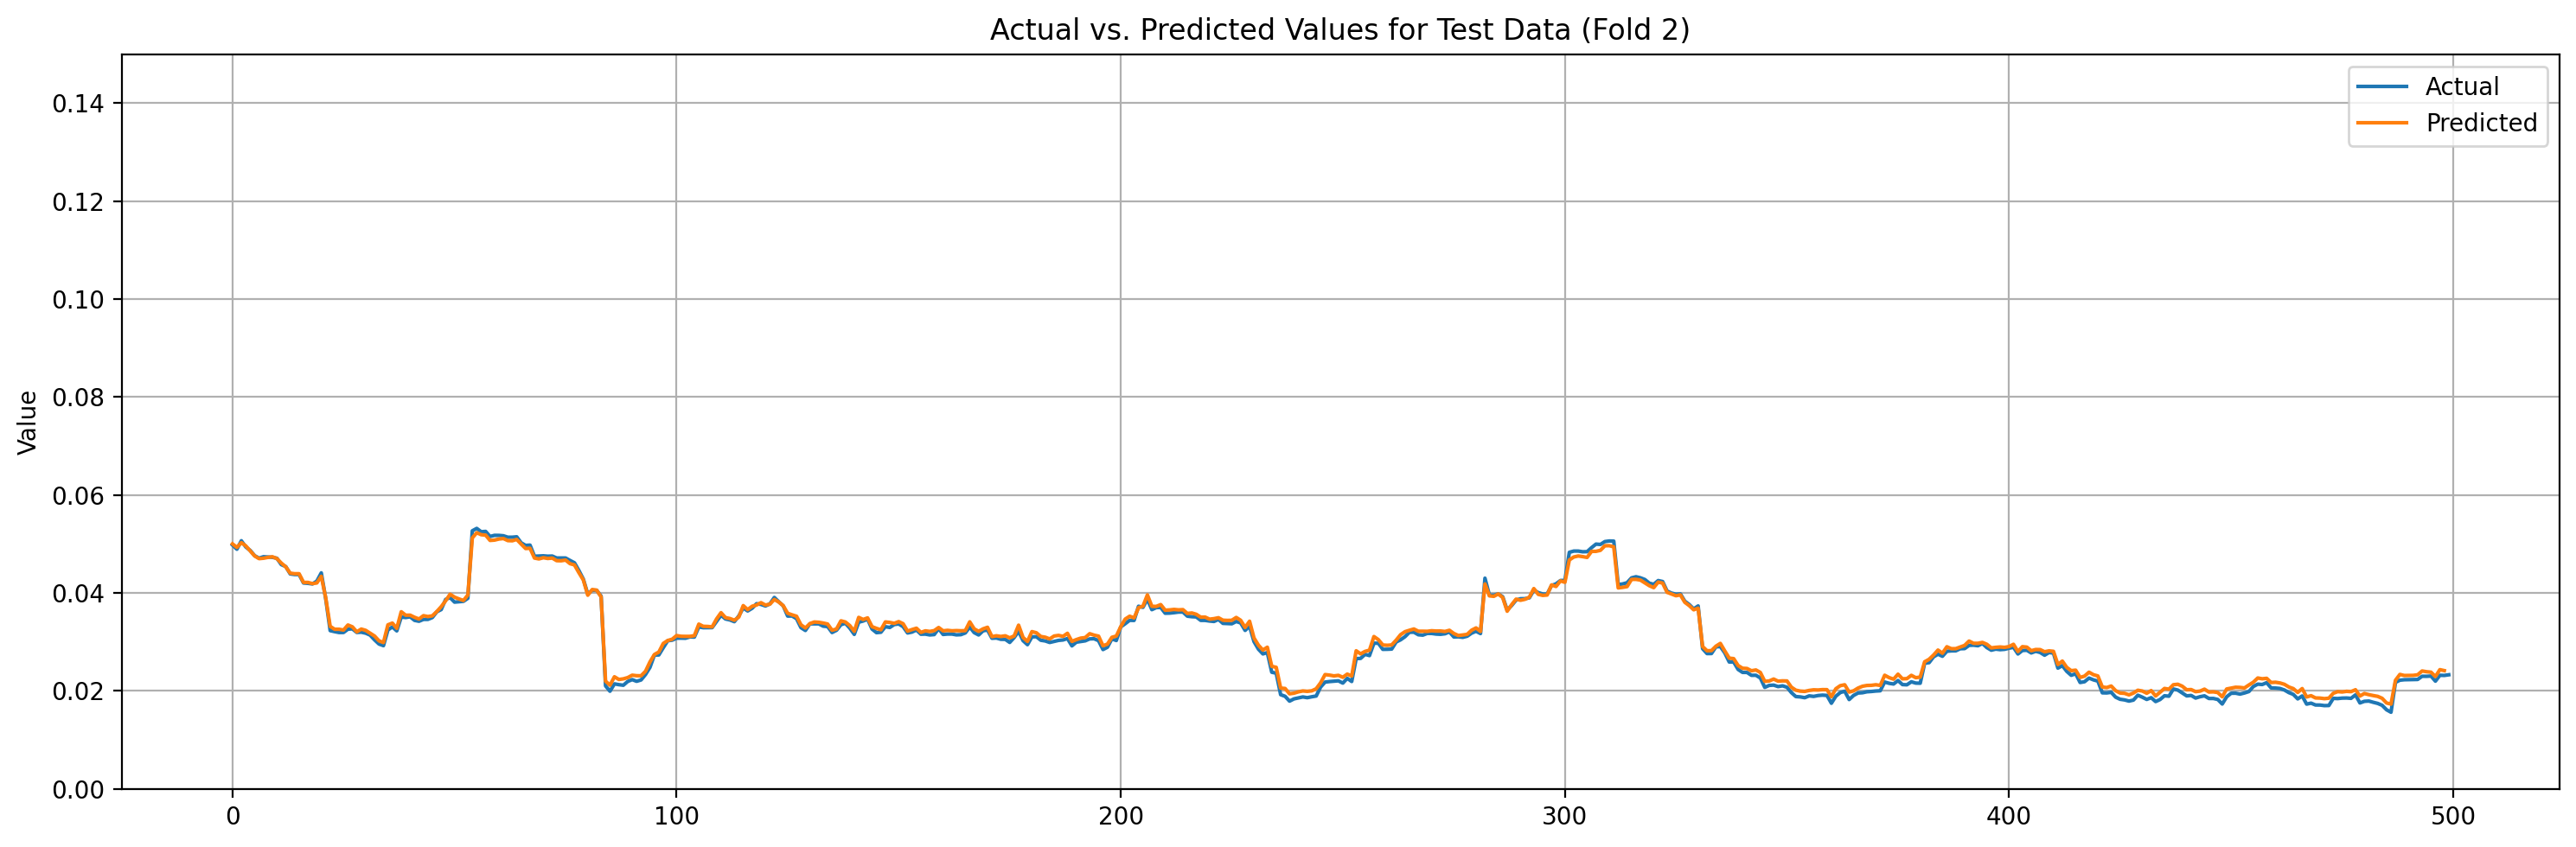

4/4 [==============================] - 0s 10ms/step - loss: 5.0186e-06 - mae: 0.0013


<Figure size 3000x1000 with 0 Axes>

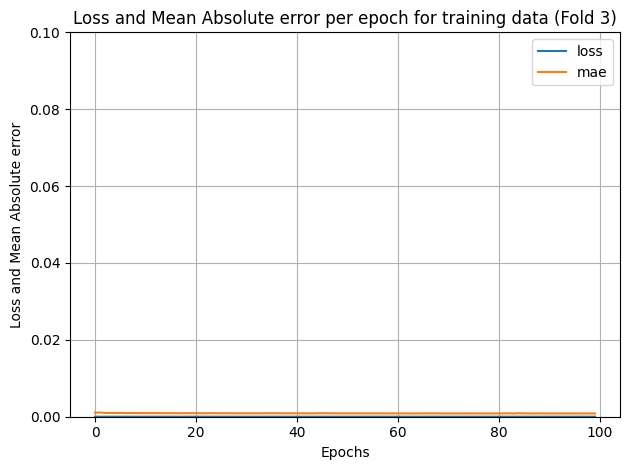

4/4 [==============================] - 0s 6ms/step


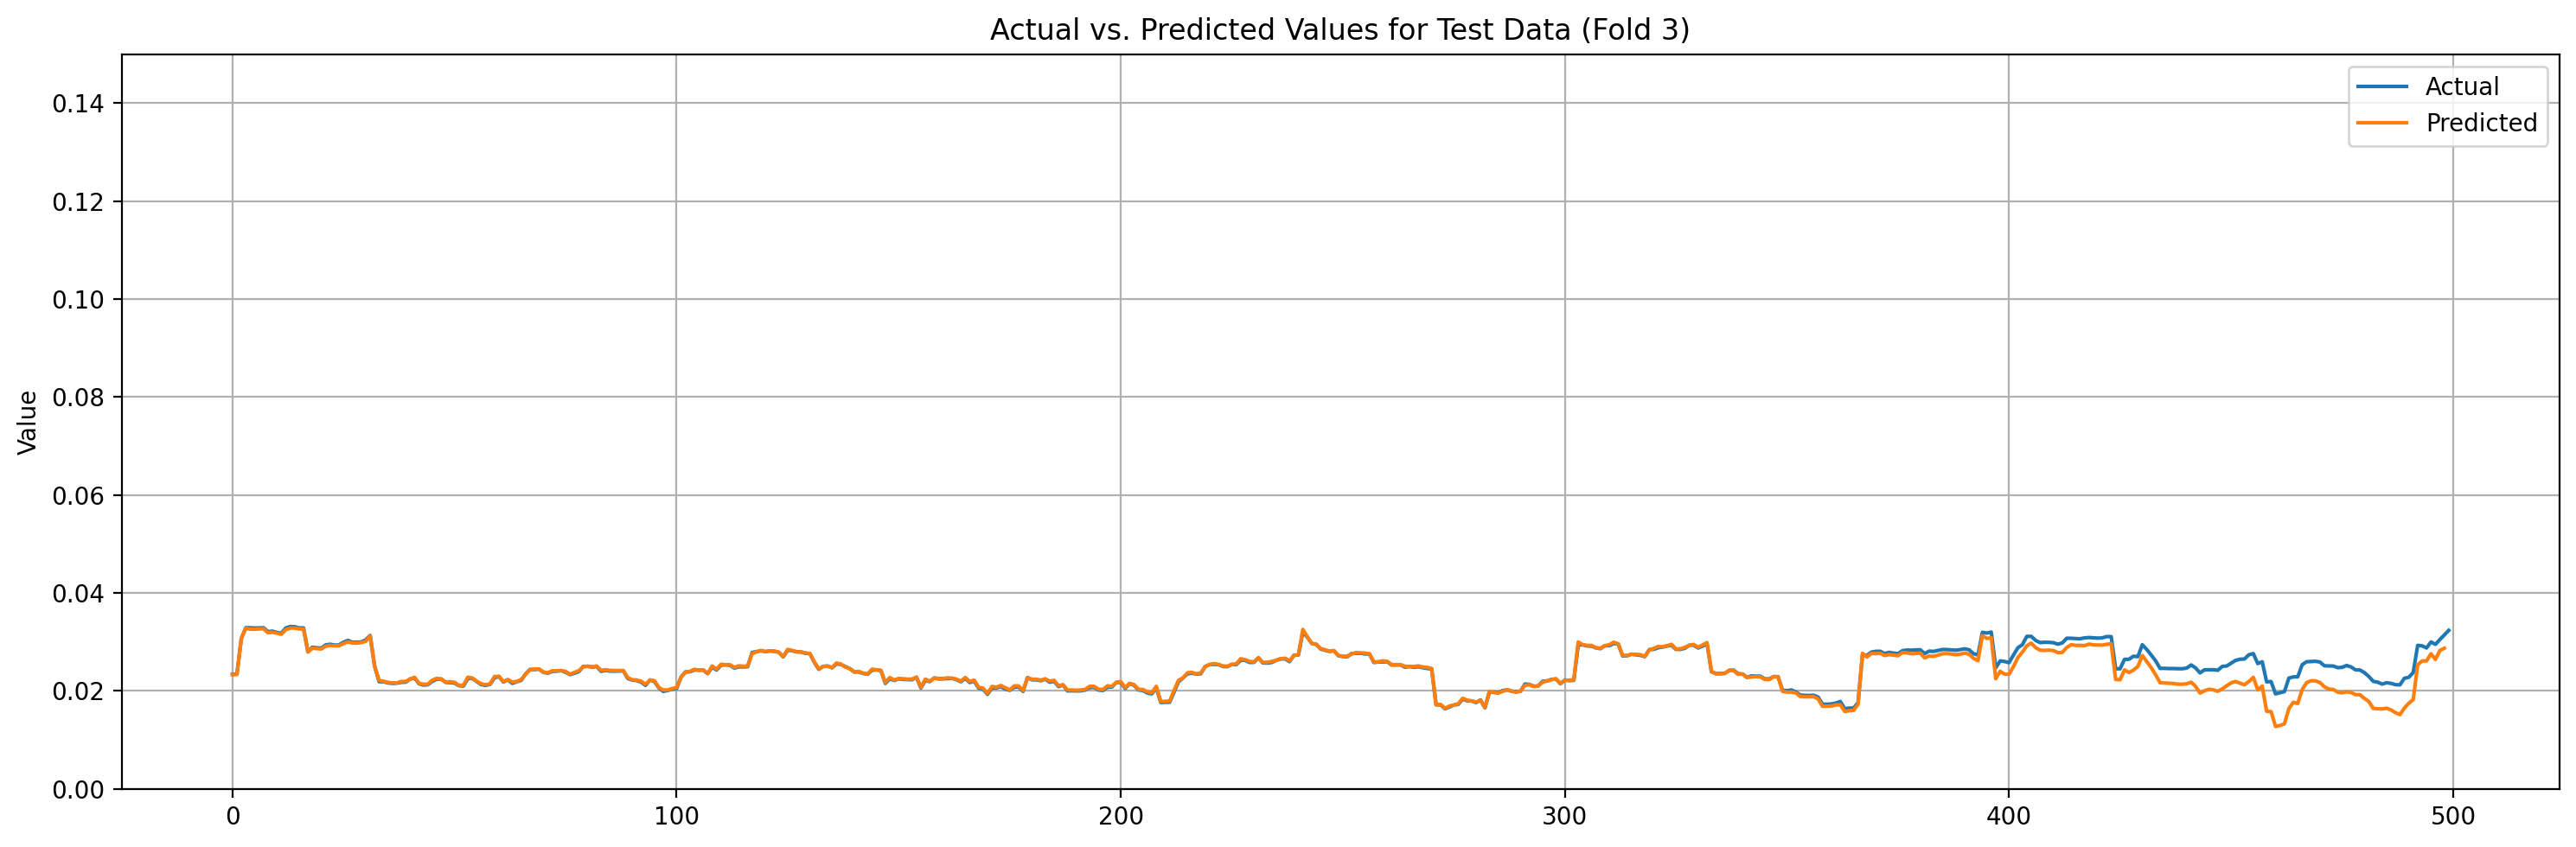

4/4 [==============================] - 0s 7ms/step - loss: 6.2133e-06 - mae: 0.0022


<Figure size 3000x1000 with 0 Axes>

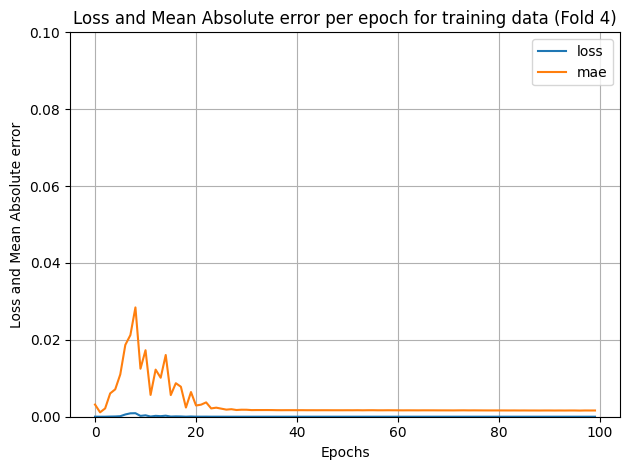

4/4 [==============================] - 0s 6ms/step


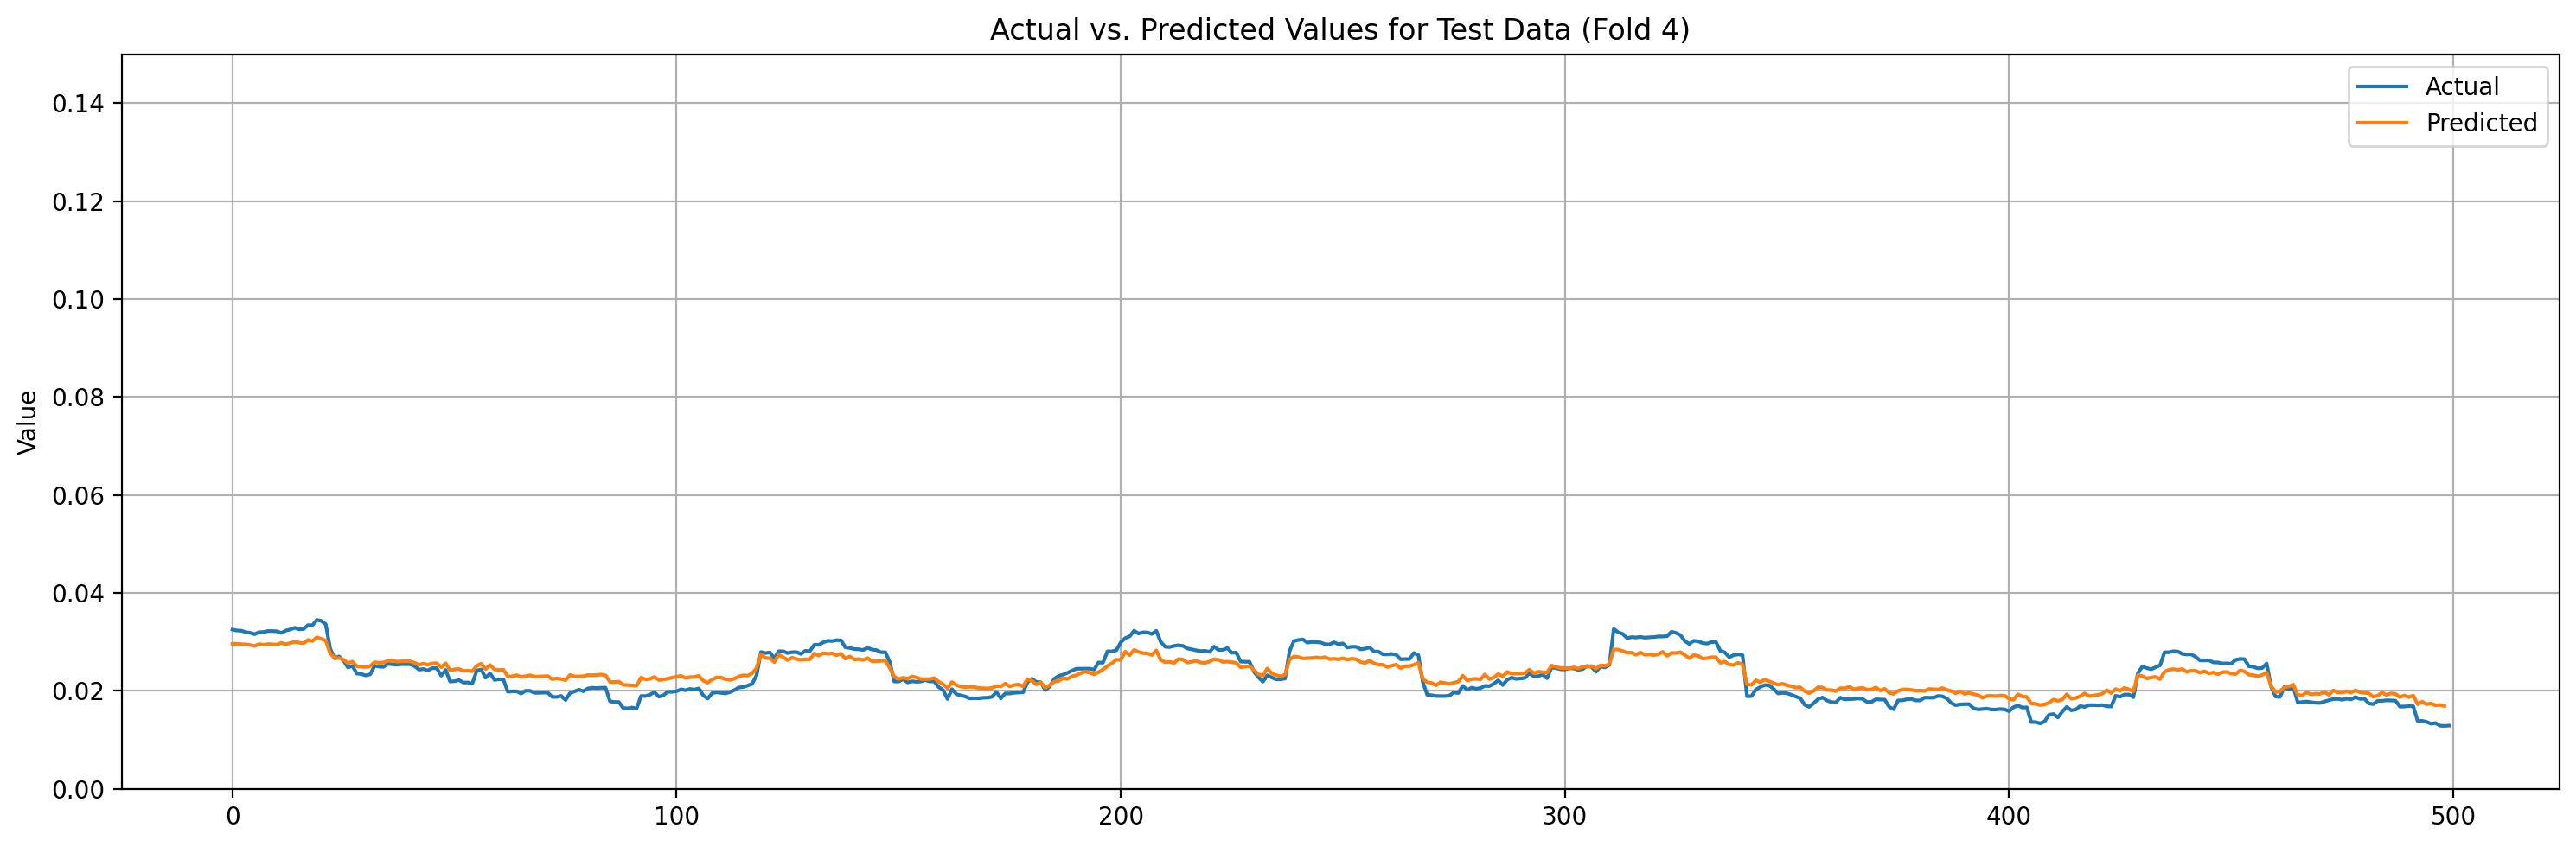

4/4 [==============================] - 0s 8ms/step - loss: 7.7482e-05 - mae: 0.0077


<Figure size 3000x1000 with 0 Axes>

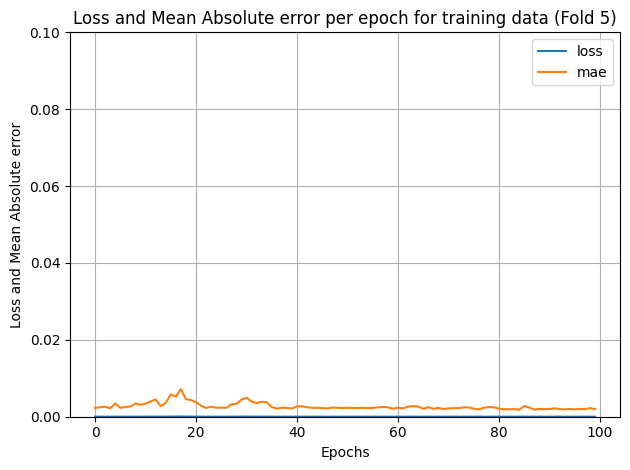

4/4 [==============================] - 0s 6ms/step


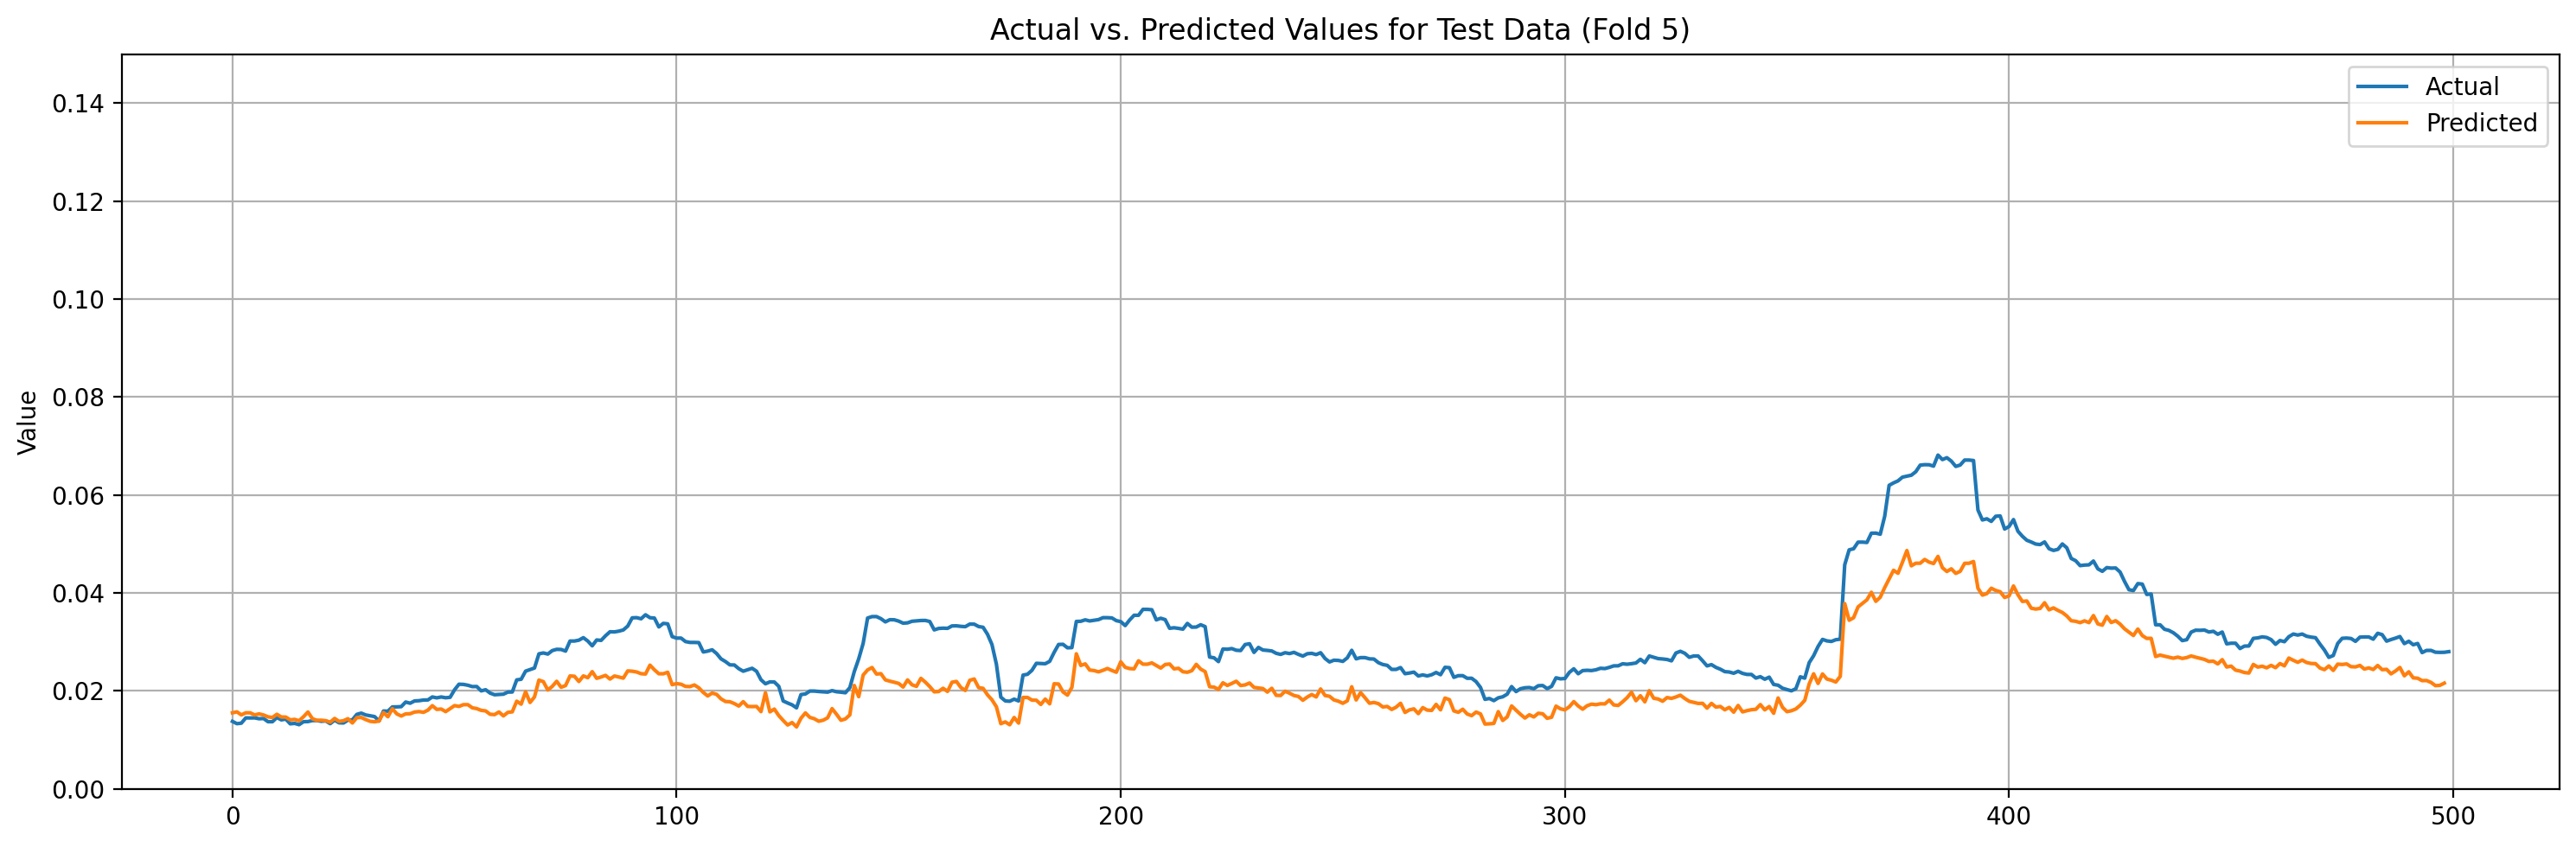

4/4 [==============================] - 0s 8ms/step - loss: 4.8041e-05 - mae: 0.0053


<Figure size 3000x1000 with 0 Axes>

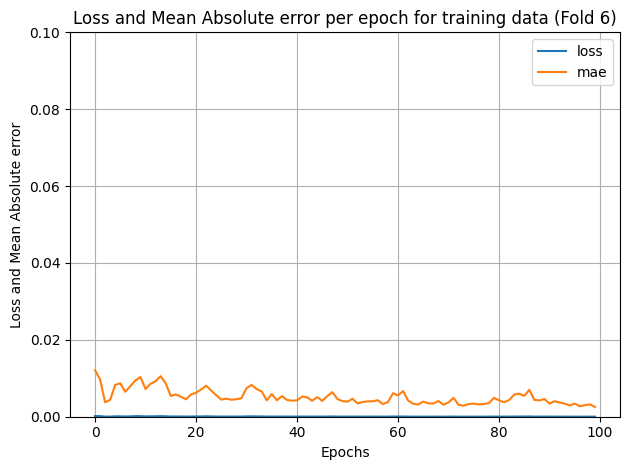

4/4 [==============================] - 0s 6ms/step


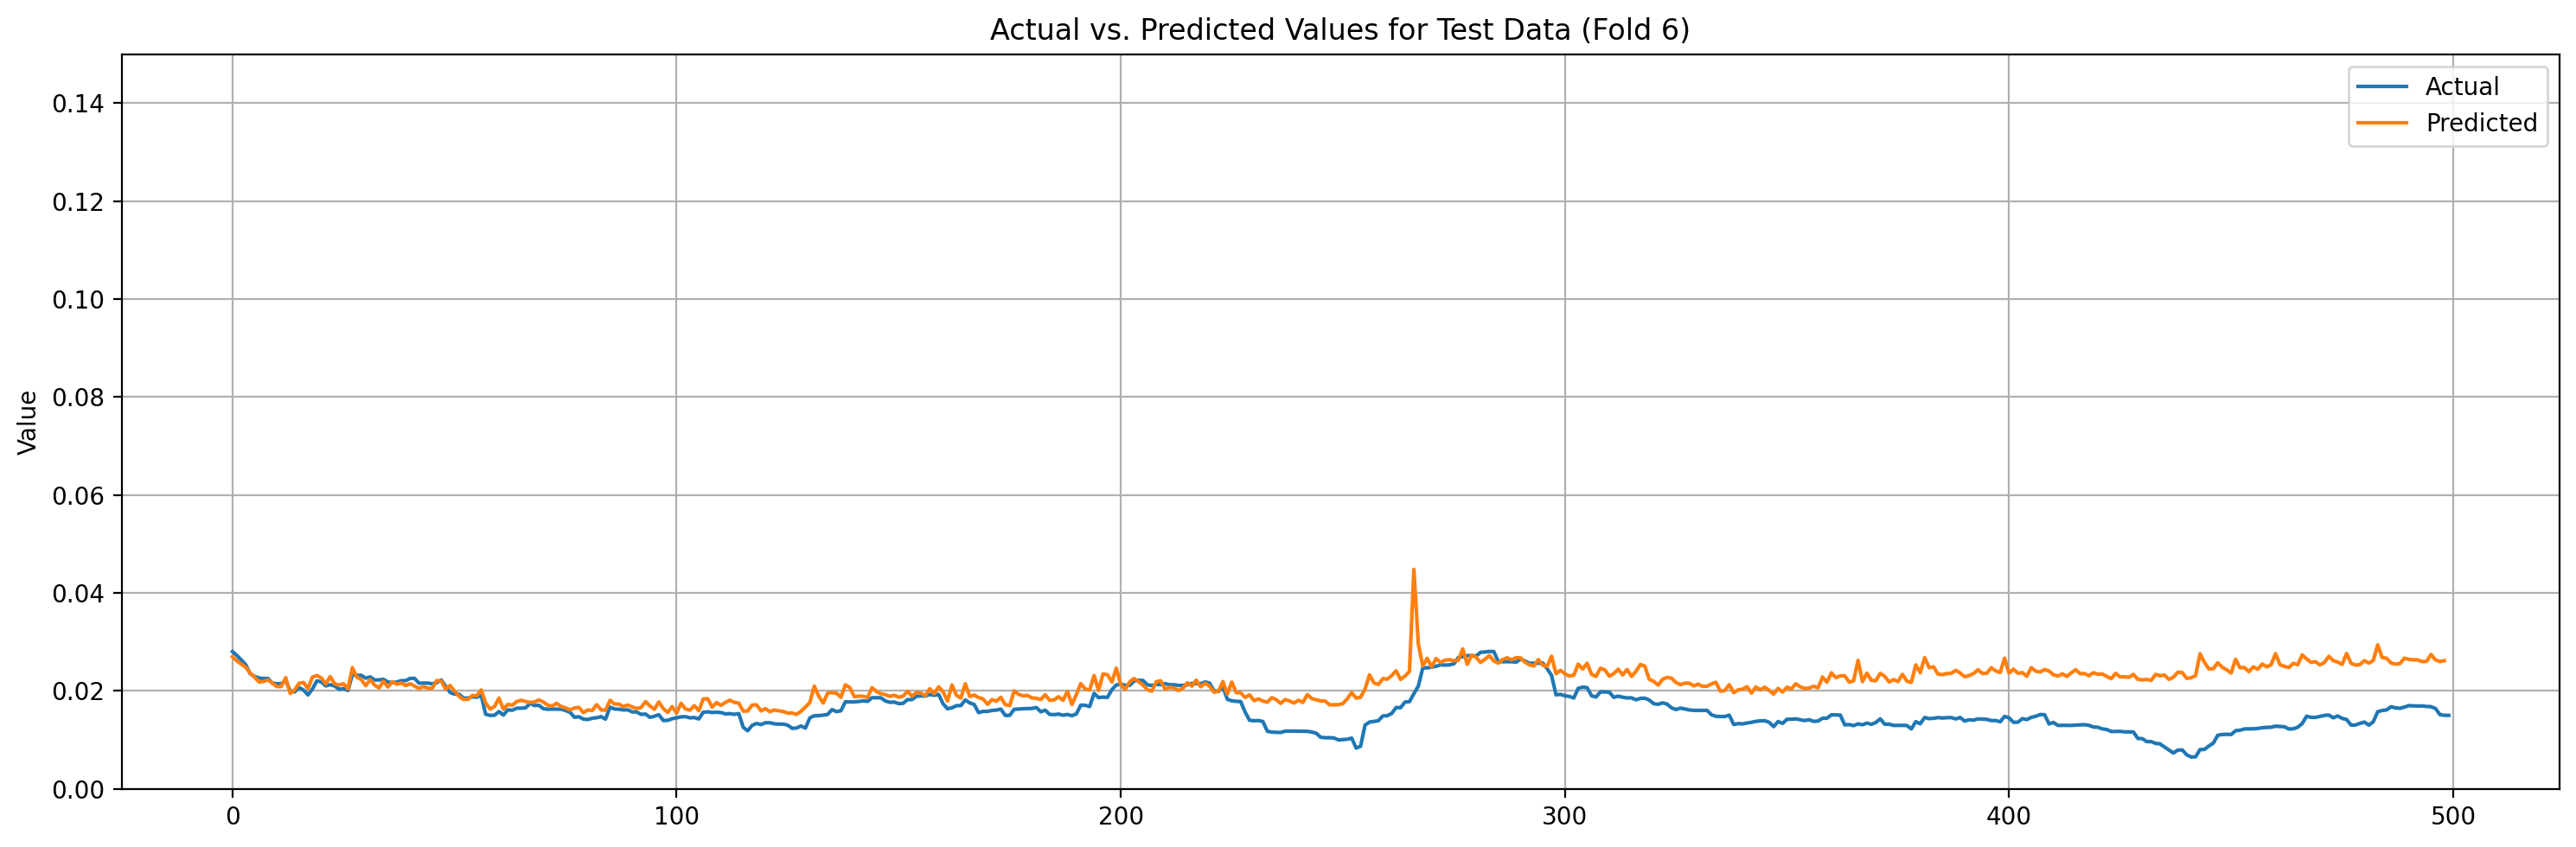

4/4 [==============================] - 0s 9ms/step - loss: 8.5694e-05 - mae: 0.0077


<Figure size 3000x1000 with 0 Axes>

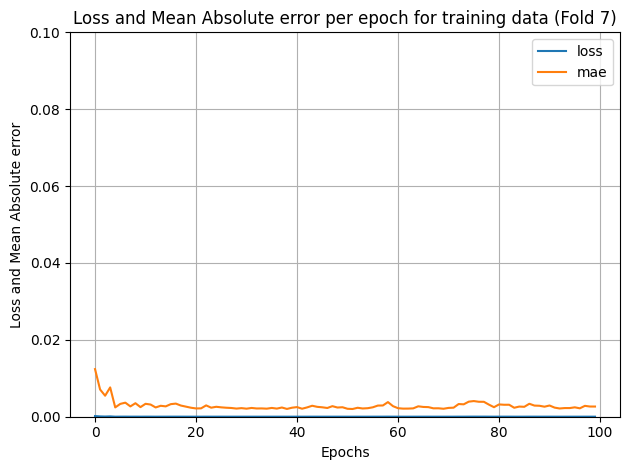

4/4 [==============================] - 0s 7ms/step


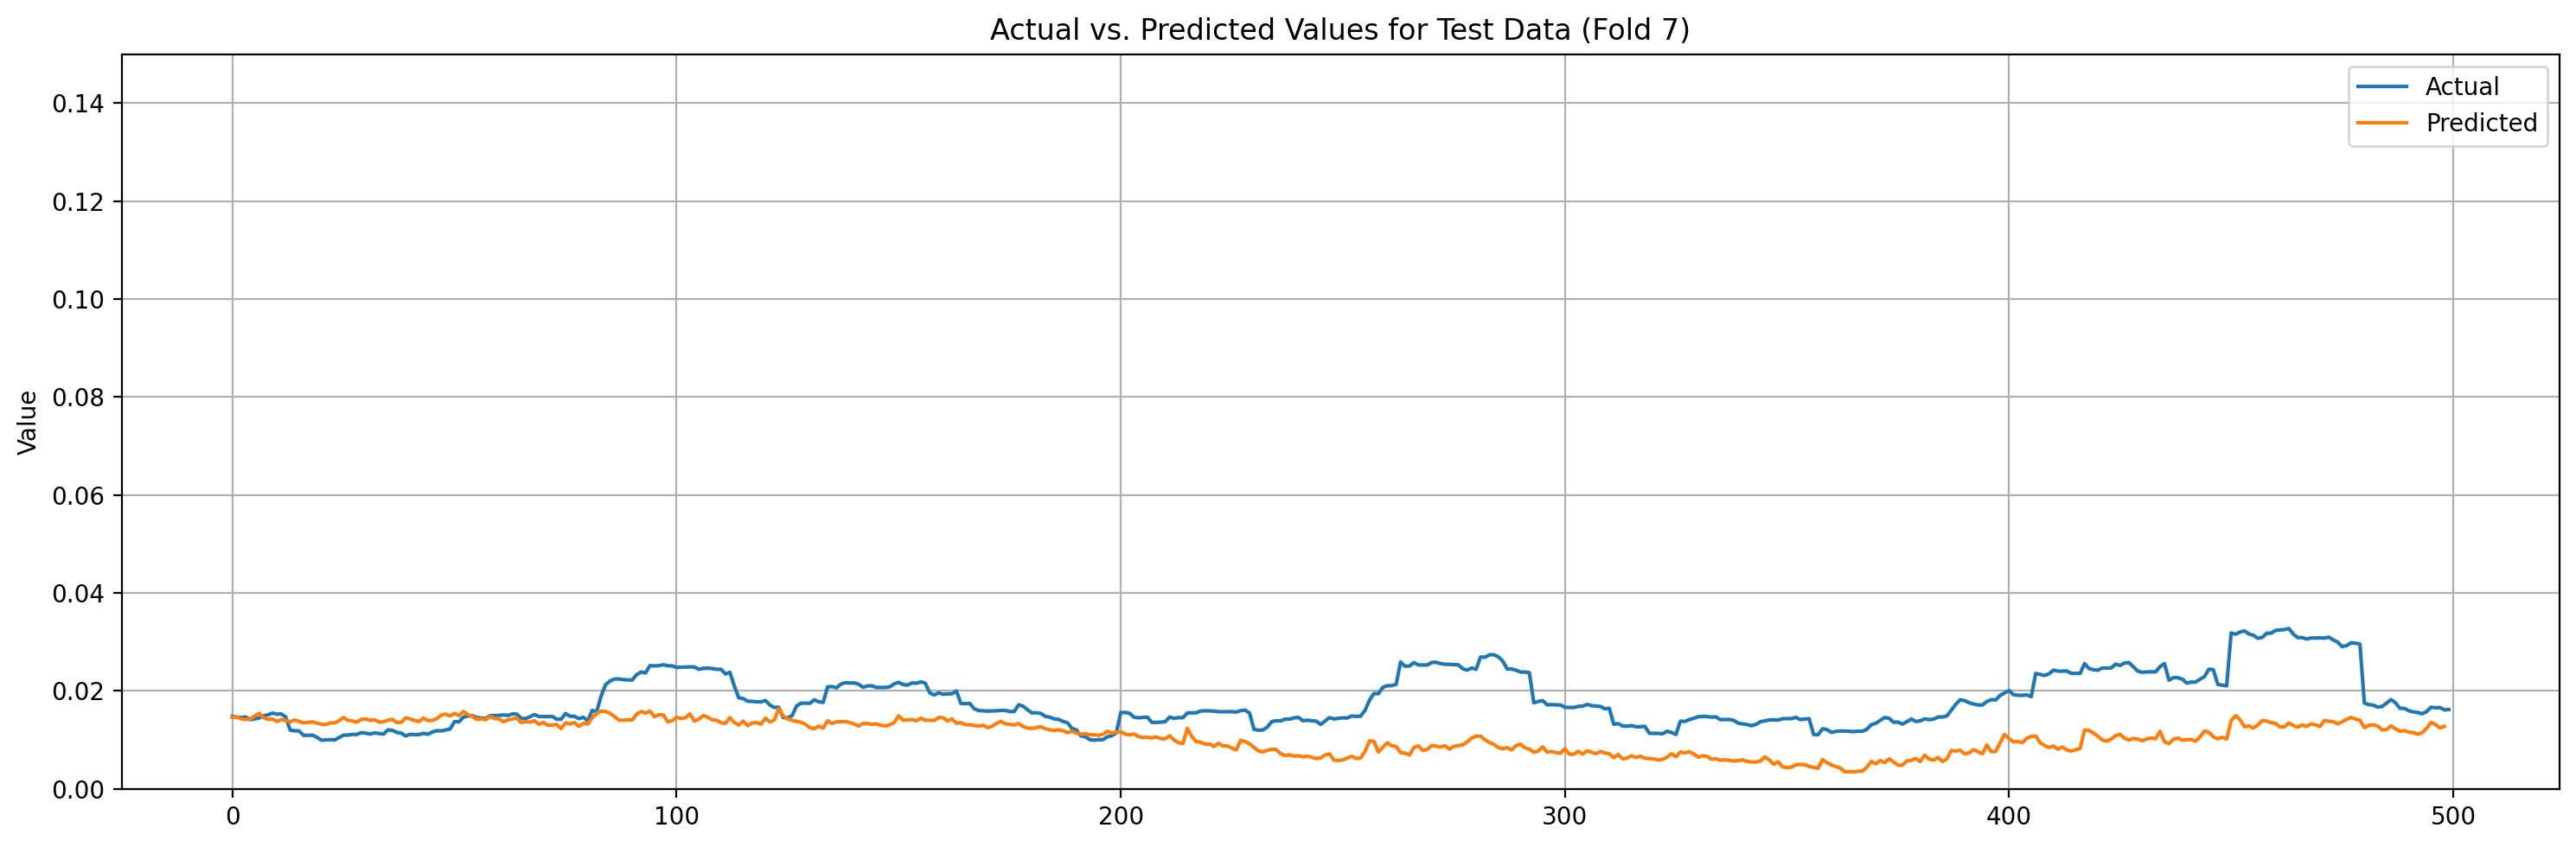

4/4 [==============================] - 0s 9ms/step - loss: 5.8929e-05 - mae: 0.0068


<Figure size 3000x1000 with 0 Axes>

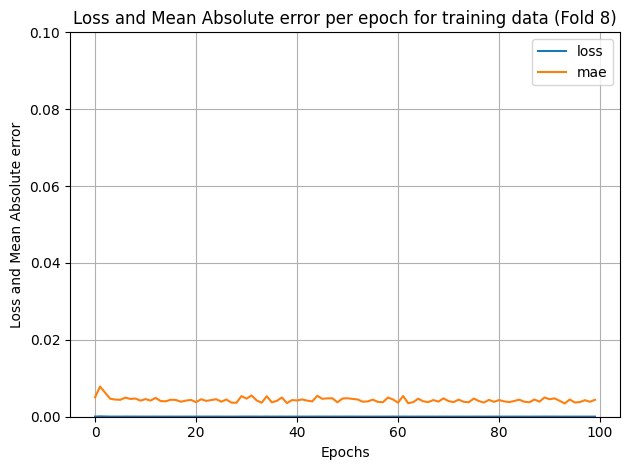

4/4 [==============================] - 0s 5ms/step


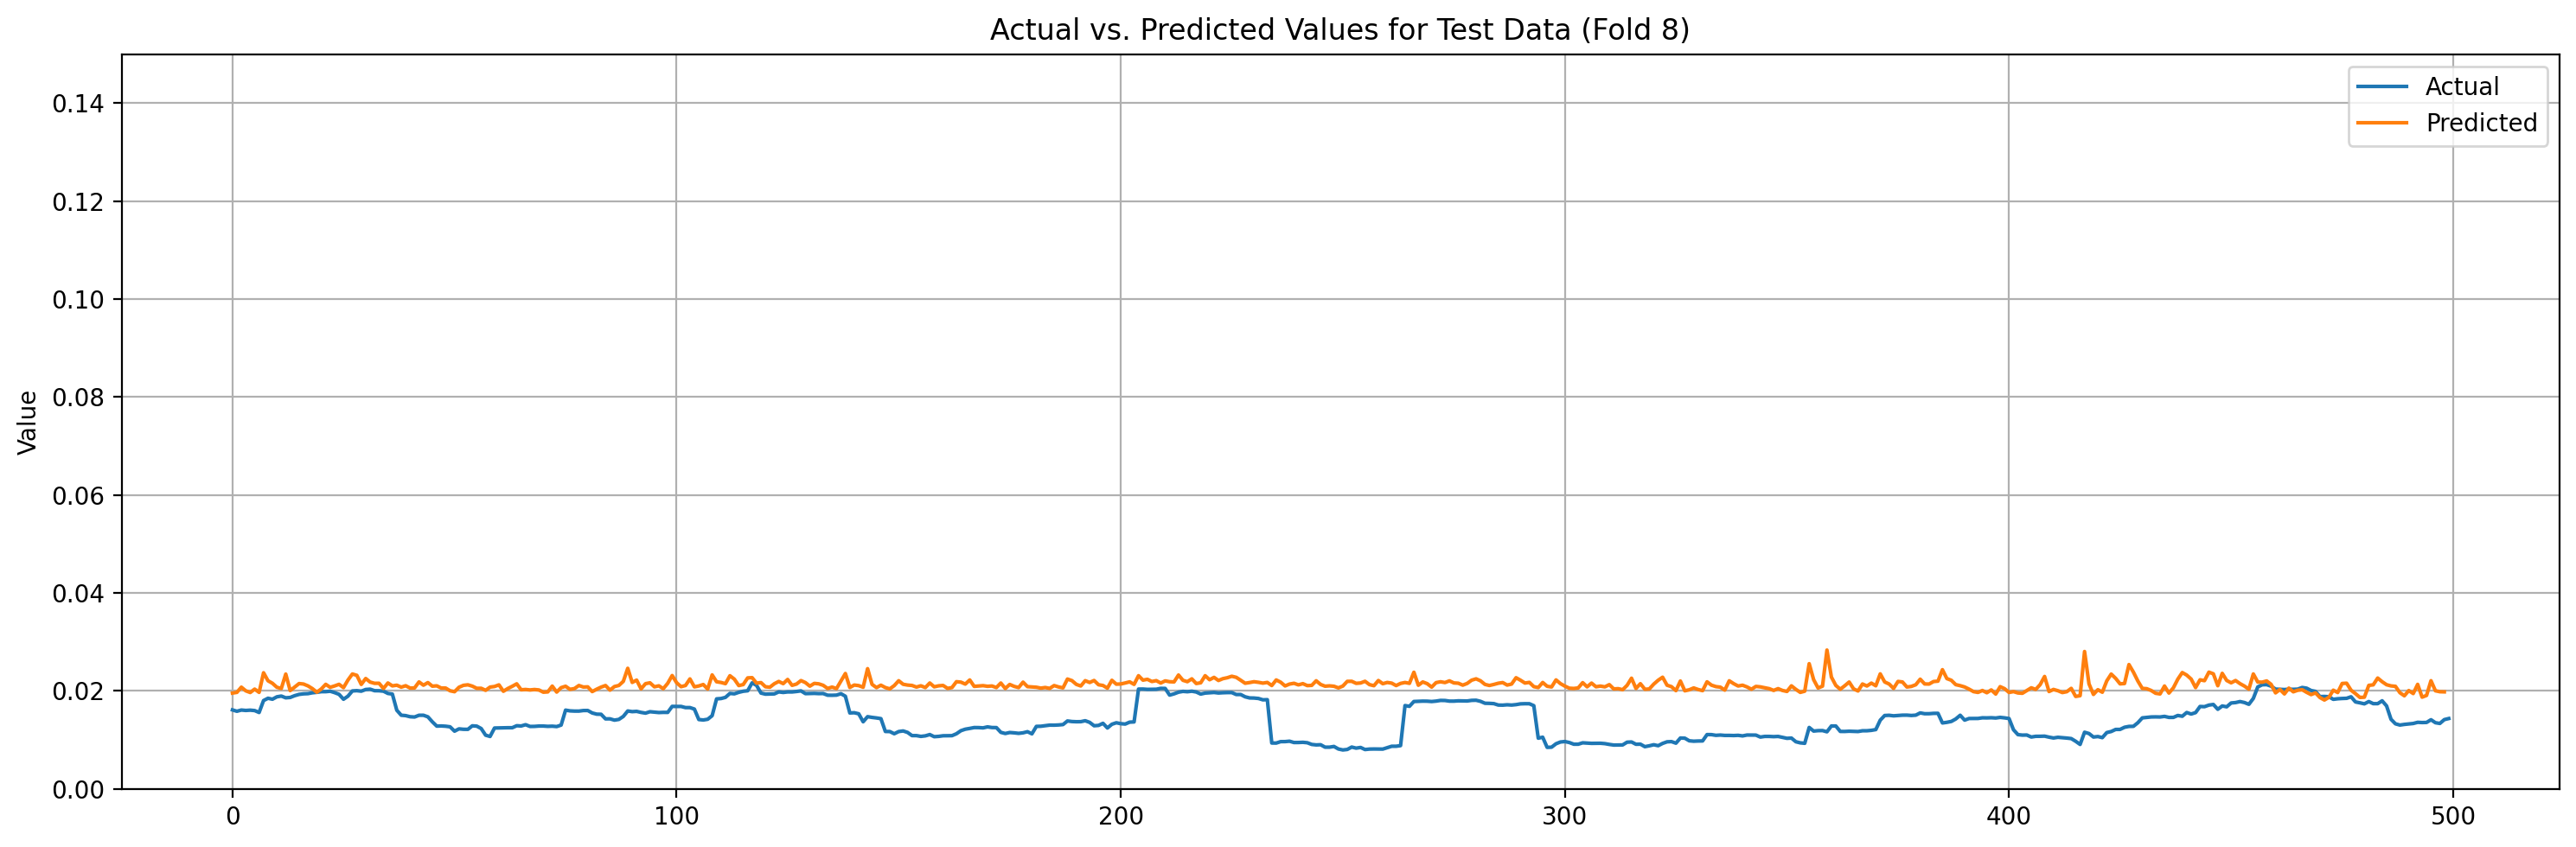

4/4 [==============================] - 0s 8ms/step - loss: 2.0088e-05 - mae: 0.0034


<Figure size 3000x1000 with 0 Axes>

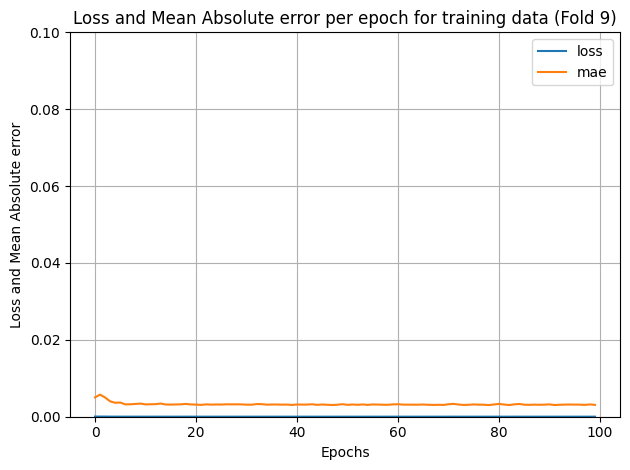

4/4 [==============================] - 0s 6ms/step


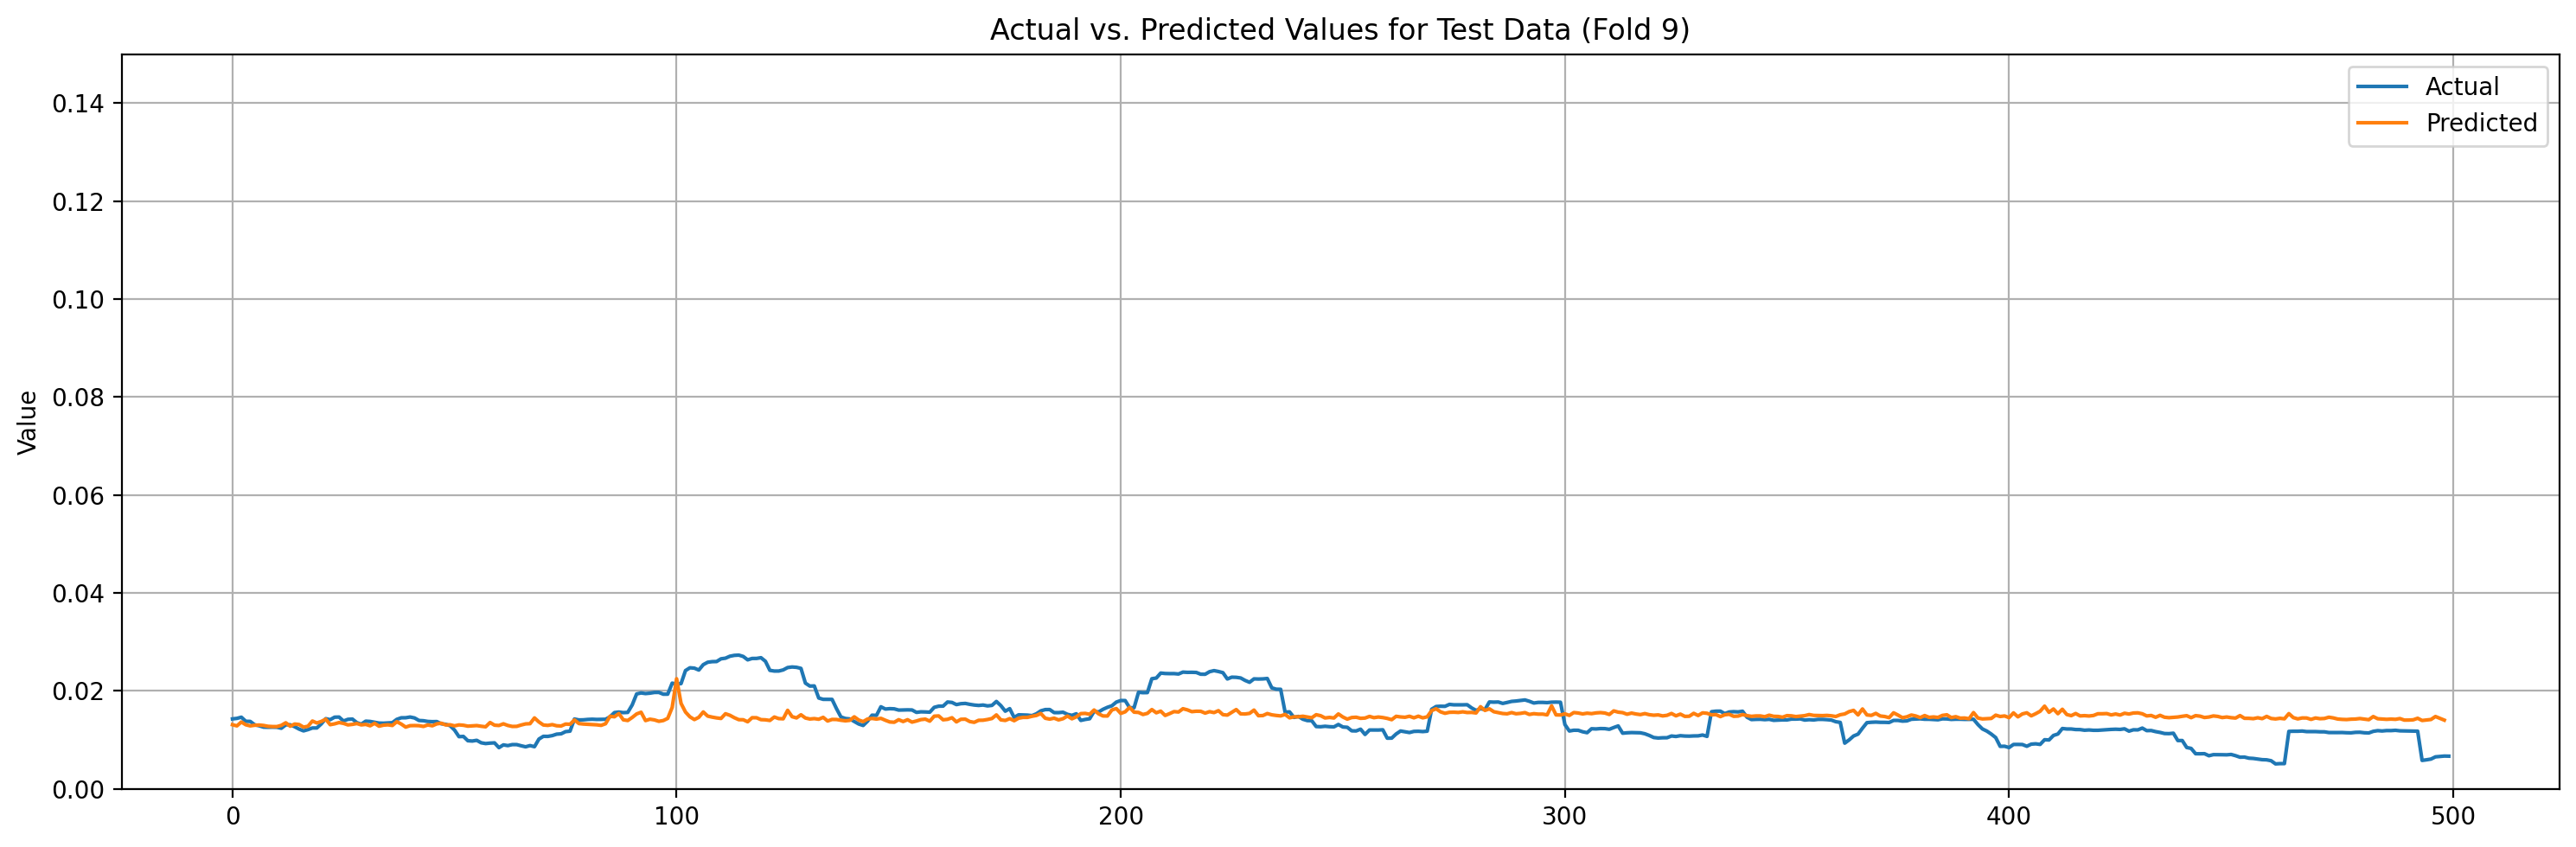

4/4 [==============================] - 0s 16ms/step - loss: 8.9446e-05 - mae: 0.0072


<Figure size 3000x1000 with 0 Axes>

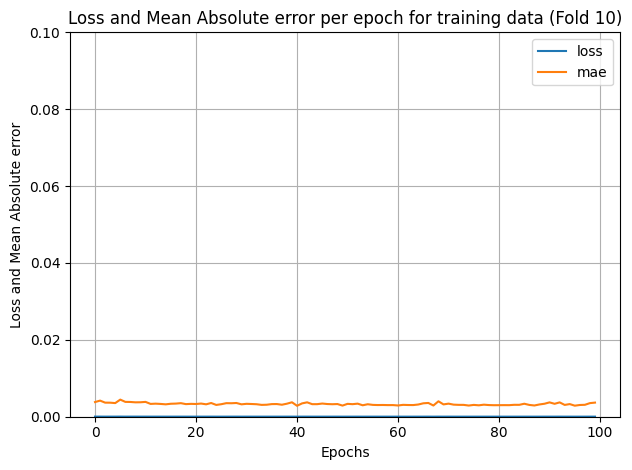

4/4 [==============================] - 0s 6ms/step


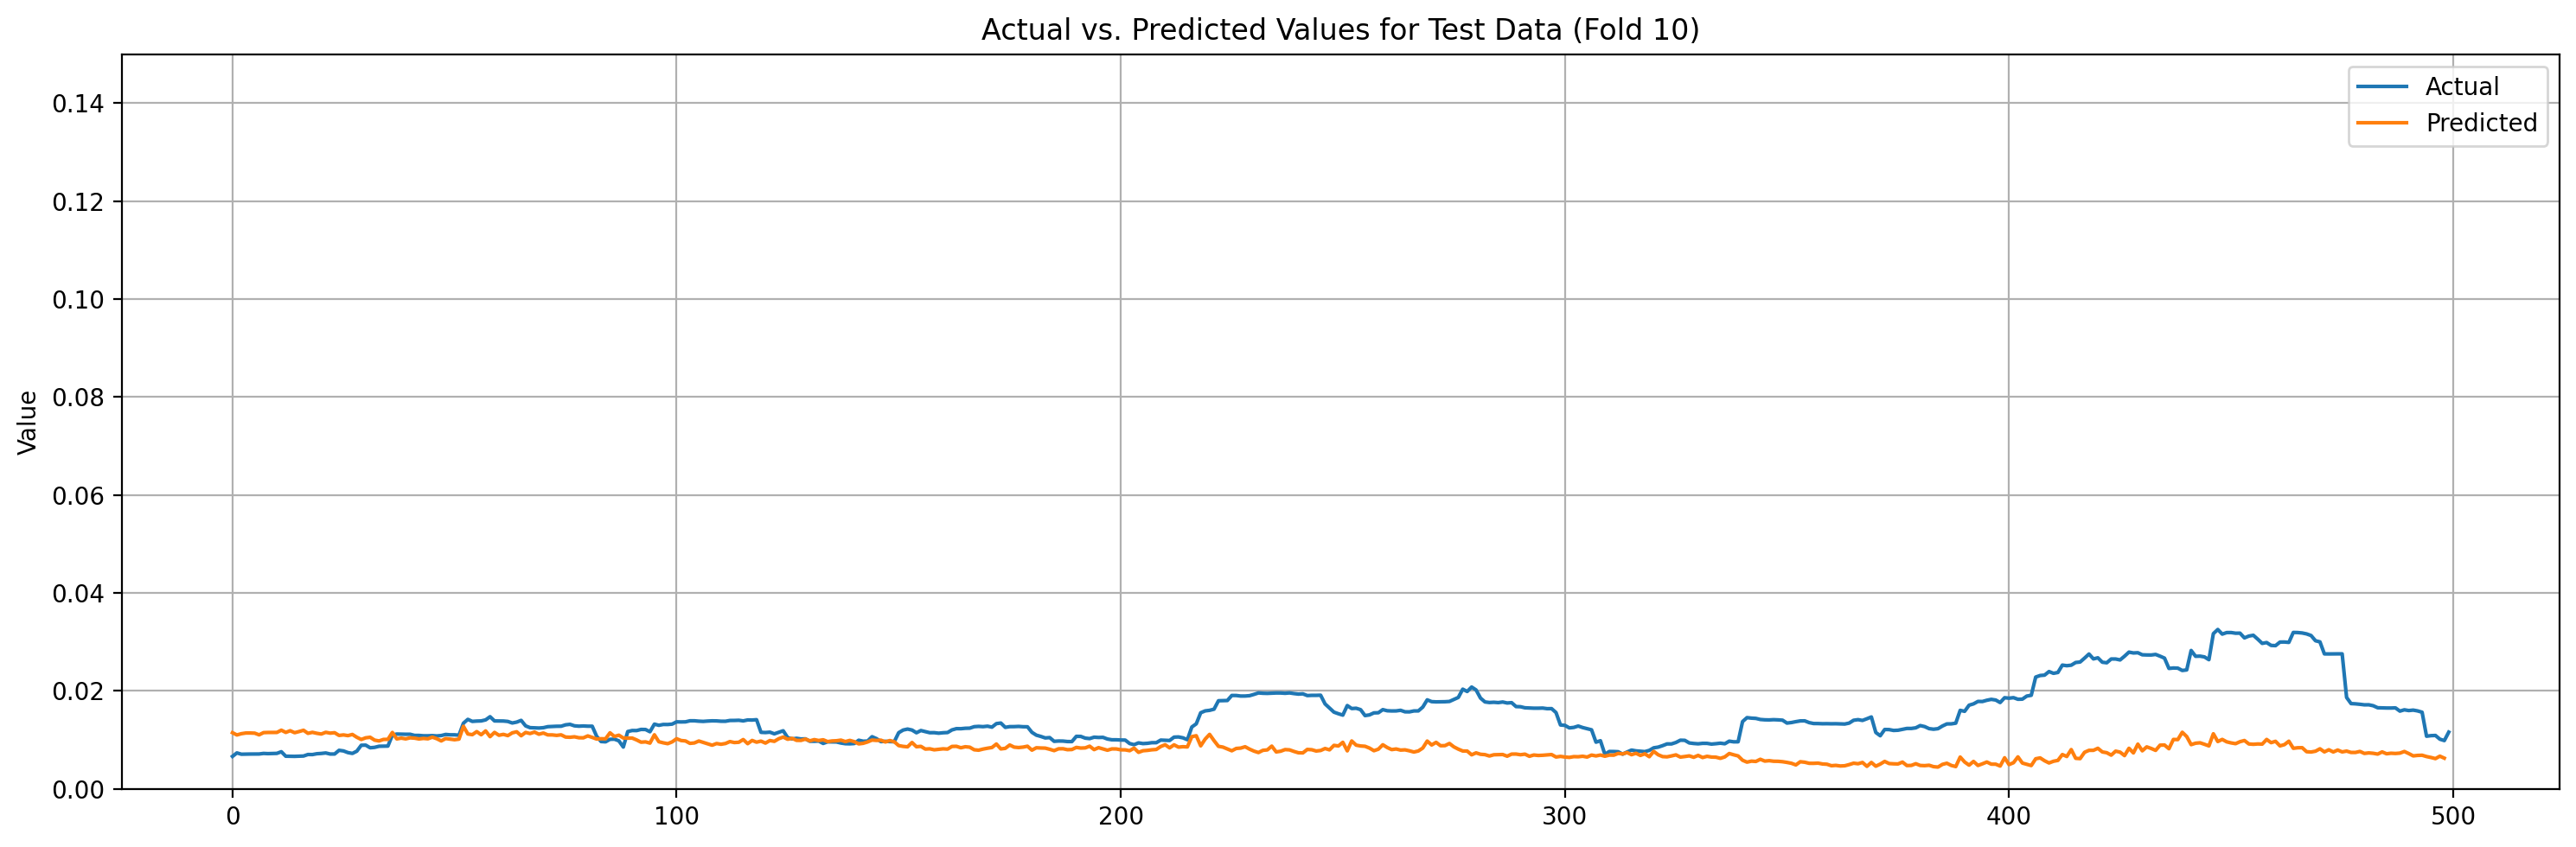

4/4 [==============================] - 0s 8ms/step - loss: 1.0534e-04 - mae: 0.0060


<Figure size 3000x1000 with 0 Axes>

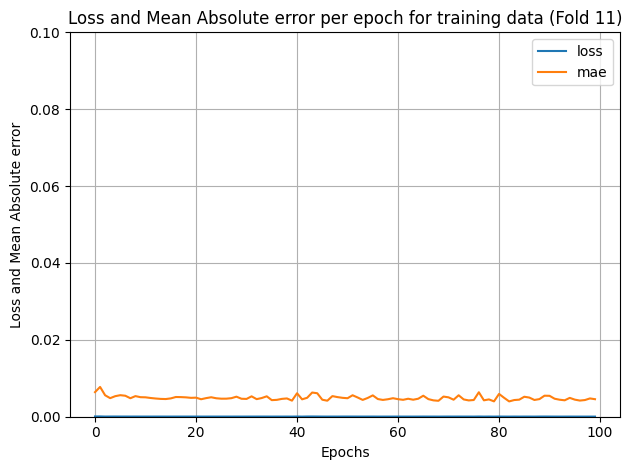

4/4 [==============================] - 0s 8ms/step


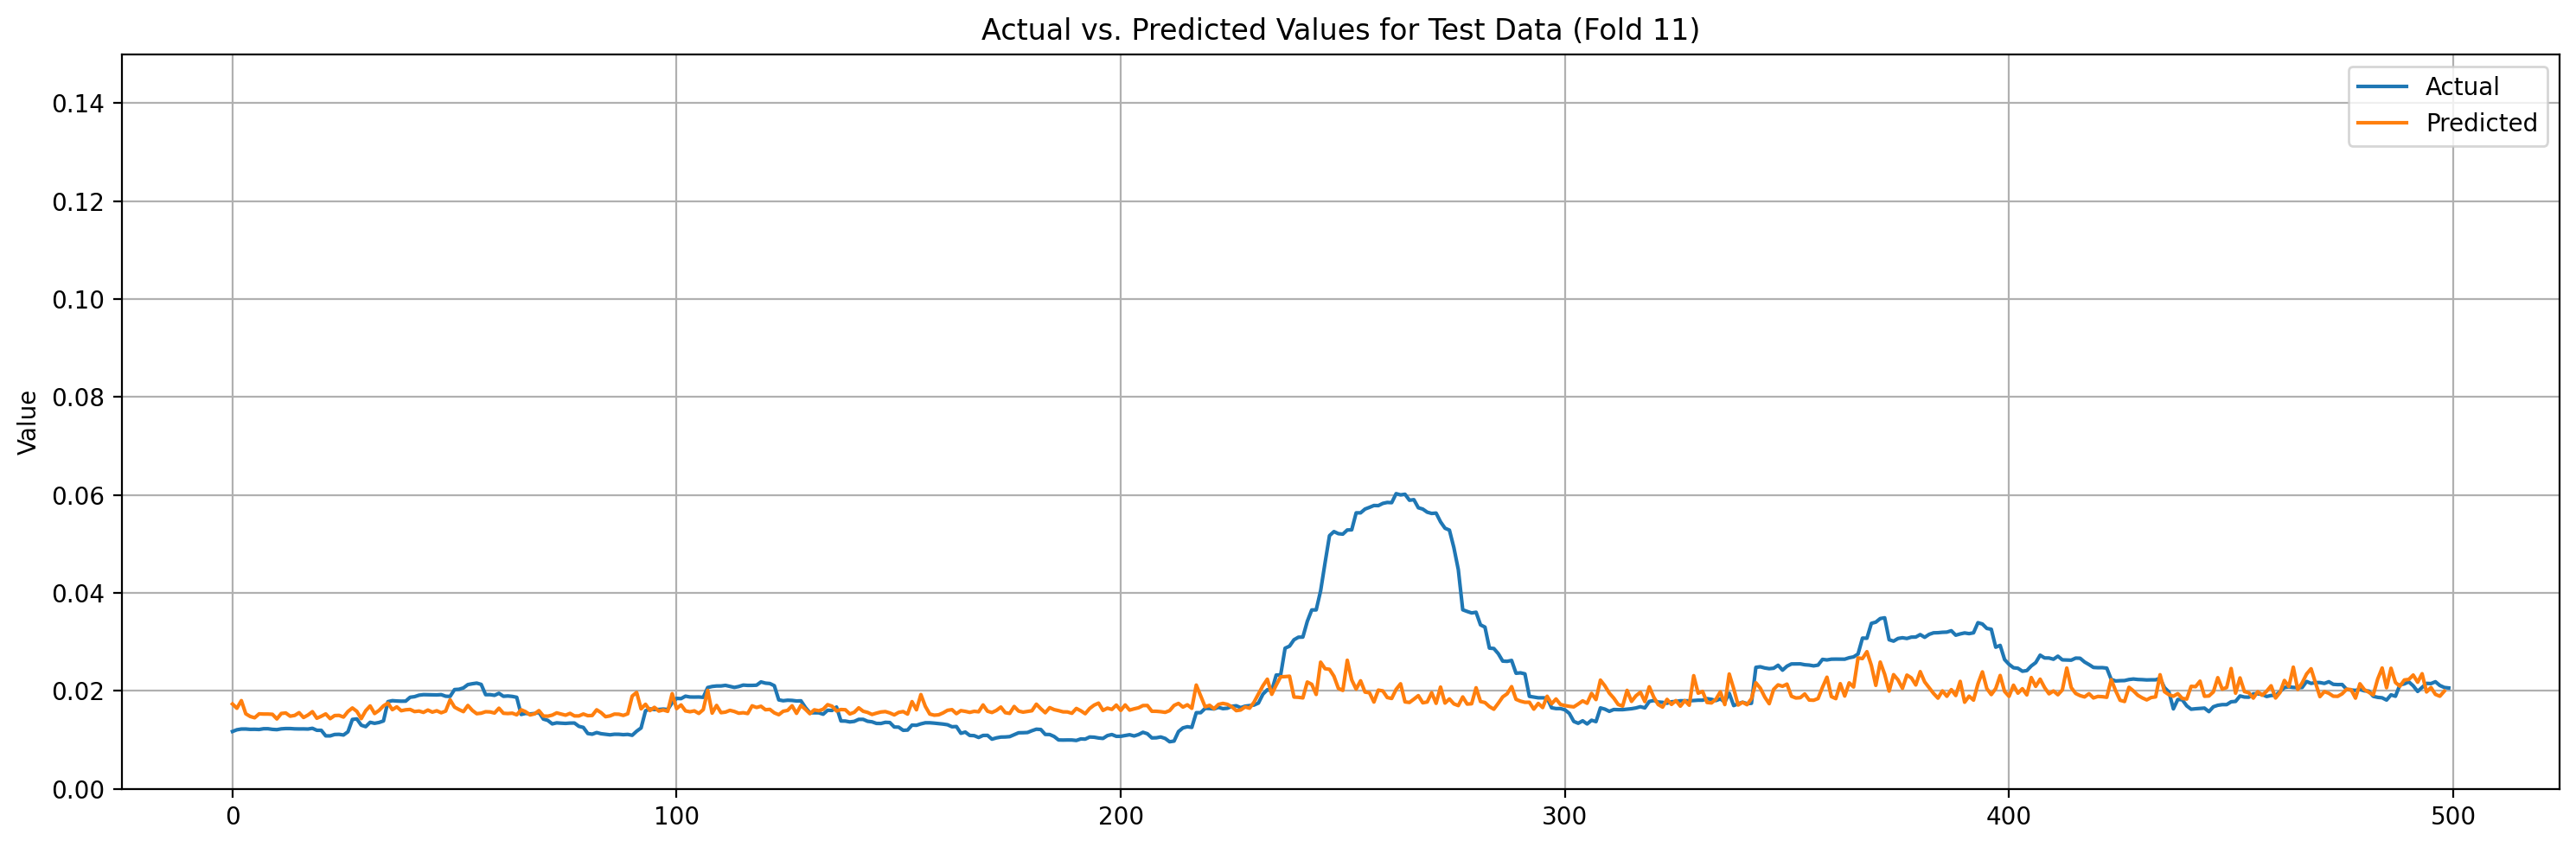

4/4 [==============================] - 0s 6ms/step - loss: 8.9896e-05 - mae: 0.0086


<Figure size 3000x1000 with 0 Axes>

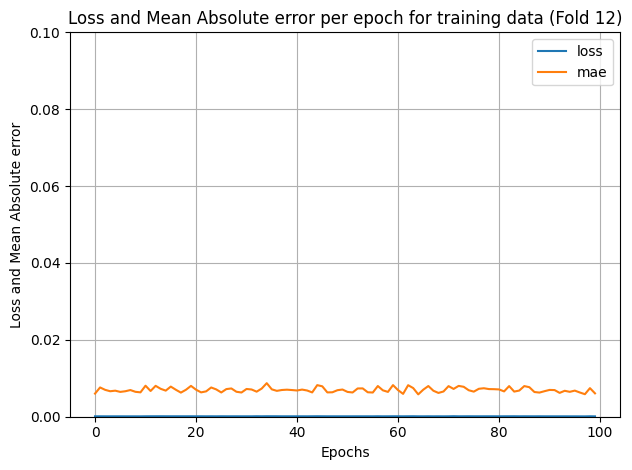

4/4 [==============================] - 0s 6ms/step


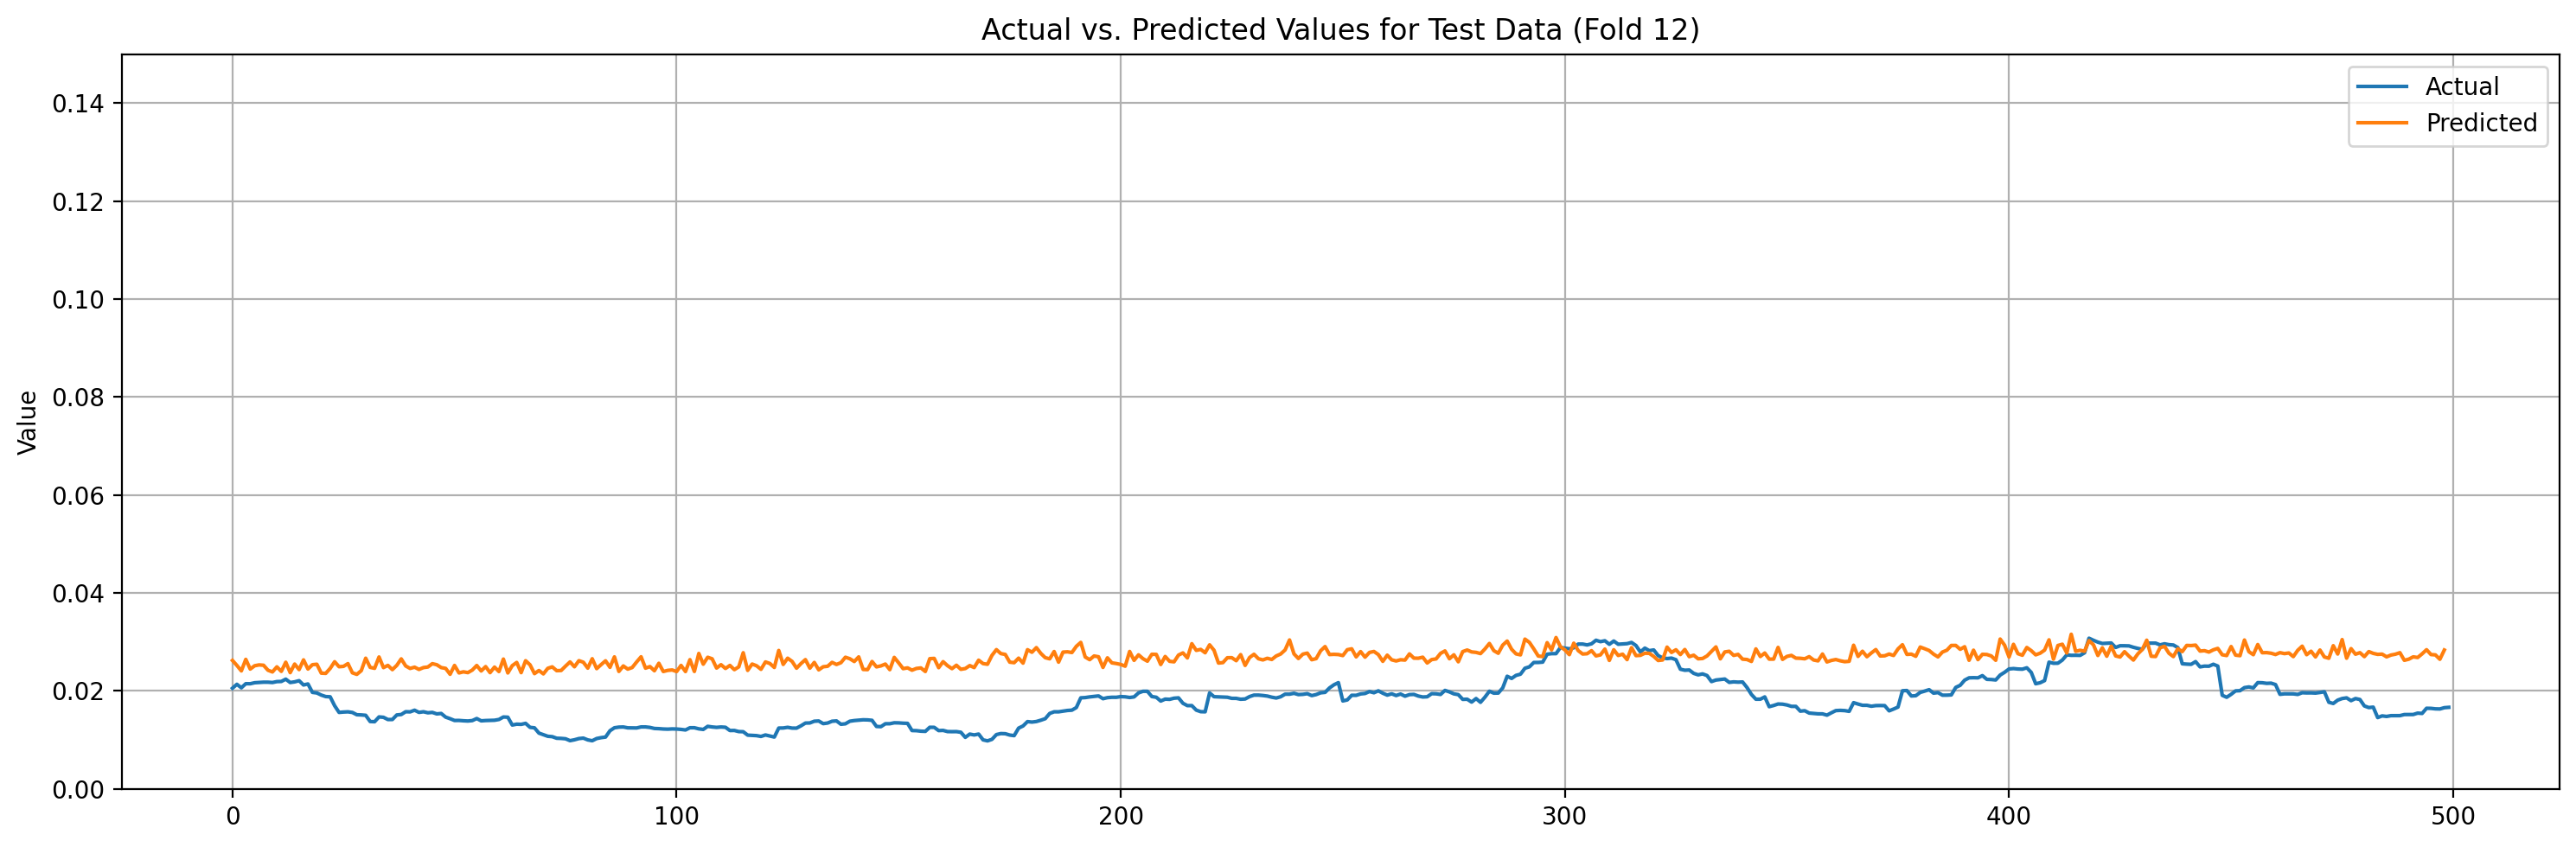

In [13]:
#creating empty lists to store loss and  MAE values for training and testing data
train_MAE = []
train_loss = [] 
test_MAE = []
test_losses = []
loss_mae_per_fold = {}

#iterating through multiple folds of training and testing data
for i, (train_index, test_index) in enumerate(tscv.split(X)):
  #splitting the data into training and testing sets 
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]

  #using to timeseriesgenerator on training and testing data to make time series between lagged samples and target
  train_gen = TimeseriesGenerator(X_train, y_train, length=W)
  test_gen = TimeseriesGenerator(X_test, y_test, length=W) 

  #fitting the model with training data
  h = model.fit(train_gen, epochs=100, verbose=False)

  #storing the result
  result = pd.DataFrame(h.history)
  
  #storing loss and MAE values for training data
  train_MAE.append(np.mean(result[['mae']].values))
  train_loss.append(np.mean(result[['loss']].values))

  #calculting and storing loss and MAE values for testing data 
  test_loss, test_mae = model.evaluate(test_gen)
  test_MAE.append(test_mae)
  test_losses.append(test_loss)

  #plotting the loss and MAE per epoch for training data
  plt.figure(figsize=(15,5), dpi=200)
  result.plot(style=['-', '-'])
  plt.ylim(0,0.1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss and Mean Absolute error')
  plt.title('Loss and Mean Absolute error per epoch for training data (Fold {})'.format(i+1))
  plt.grid()
  plt.tight_layout()
  plt.show();

  #displaying loss and MAE for testing data
  loss_mae_per_fold[i+1] = (test_loss, test_mae)

  #getting the predicted values for the test set
  y_test_predicted = model.predict(test_gen)

  # Plot actual and predicted values for test data
  plt.figure(figsize=(15,5), dpi=200)
  plt.plot(range(len(y_test)), y_test, label='Actual')
  plt.plot(range(len(y_test_predicted)), y_test_predicted, label='Predicted')
  plt.ylim(0,0.15)
  plt.ylabel('Value')
  plt.title('Actual vs. Predicted Values for Test Data (Fold {})'.format(i+1))
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show();

In [14]:
print('Loss and MAE for each fold of testing data: ')
for i,(test_loss, test_mae) in loss_mae_per_fold.items():
  print('Fold: {} | Loss = {} | MAE = {}'. format(i, test_loss, test_mae))

#displaying the average MAE for testing and training data
print()
print('Average Mean Absolute Error for training data: {}'.format(np.mean(train_MAE)))
print('Average Loss for training data: {}'.format(np.mean(train_loss)))
print('Average Mean Absolute Error for testing data: {}'.format(np.mean(test_MAE)))
print('Average Loss for testing data: {}'.format(np.mean(test_losses)))

Loss and MAE for each fold of testing data: 
Fold: 1 | Loss = 0.000161248492076993 | MAE = 0.008118309080600739
Fold: 2 | Loss = 3.3054225241357926e-06 | MAE = 0.0011482152622193098
Fold: 3 | Loss = 5.018619503971422e-06 | MAE = 0.0013069232227280736
Fold: 4 | Loss = 6.2132562561600935e-06 | MAE = 0.0022148110438138247
Fold: 5 | Loss = 7.74815198383294e-05 | MAE = 0.007720127236098051
Fold: 6 | Loss = 4.804061245522462e-05 | MAE = 0.005262973252683878
Fold: 7 | Loss = 8.56943370308727e-05 | MAE = 0.0077378046698868275
Fold: 8 | Loss = 5.8928821090376005e-05 | MAE = 0.006761936936527491
Fold: 9 | Loss = 2.0088302335352637e-05 | MAE = 0.003393286606296897
Fold: 10 | Loss = 8.94458862603642e-05 | MAE = 0.0071809361688792706
Fold: 11 | Loss = 0.00010534386819927022 | MAE = 0.006032438948750496
Fold: 12 | Loss = 8.989552588900551e-05 | MAE = 0.00855411496013403

Average Mean Absolute Error for training data: 0.004231101798601837
Average Loss for training data: 4.646906434250771e-05
Average 

## Ensemble Methods

In [15]:
#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.7, 
                                                    shuffle=False, 
                                                    random_state=0)

In [16]:
grid_search_params = {
    'learning_rate': [0.0005, 0.001, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.2, 0.5, 0.8],
    'max_depth': [2, 3, 4, 5]
}

# construct model
xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")

# construct grid searching 
grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, 
                    scoring='neg_mean_squared_error',
                    cv=4, verbose=1)

# fitting the data
grid.fit(X_train, y_train)


# printing fitting result
print("GridSearchCV")
print("Best parameters found for training: ", grid.best_params_)
print("Lowest RMSE found for training: ", np.sqrt(np.abs(grid.best_score_)))

y_pred = grid.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
print('RMSE for testing: ', rmse)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
GridSearchCV
Best parameters found for training:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.5}
Lowest RMSE found for training:  0.008492206645679906
RMSE for testing:  0.0028050849152728152


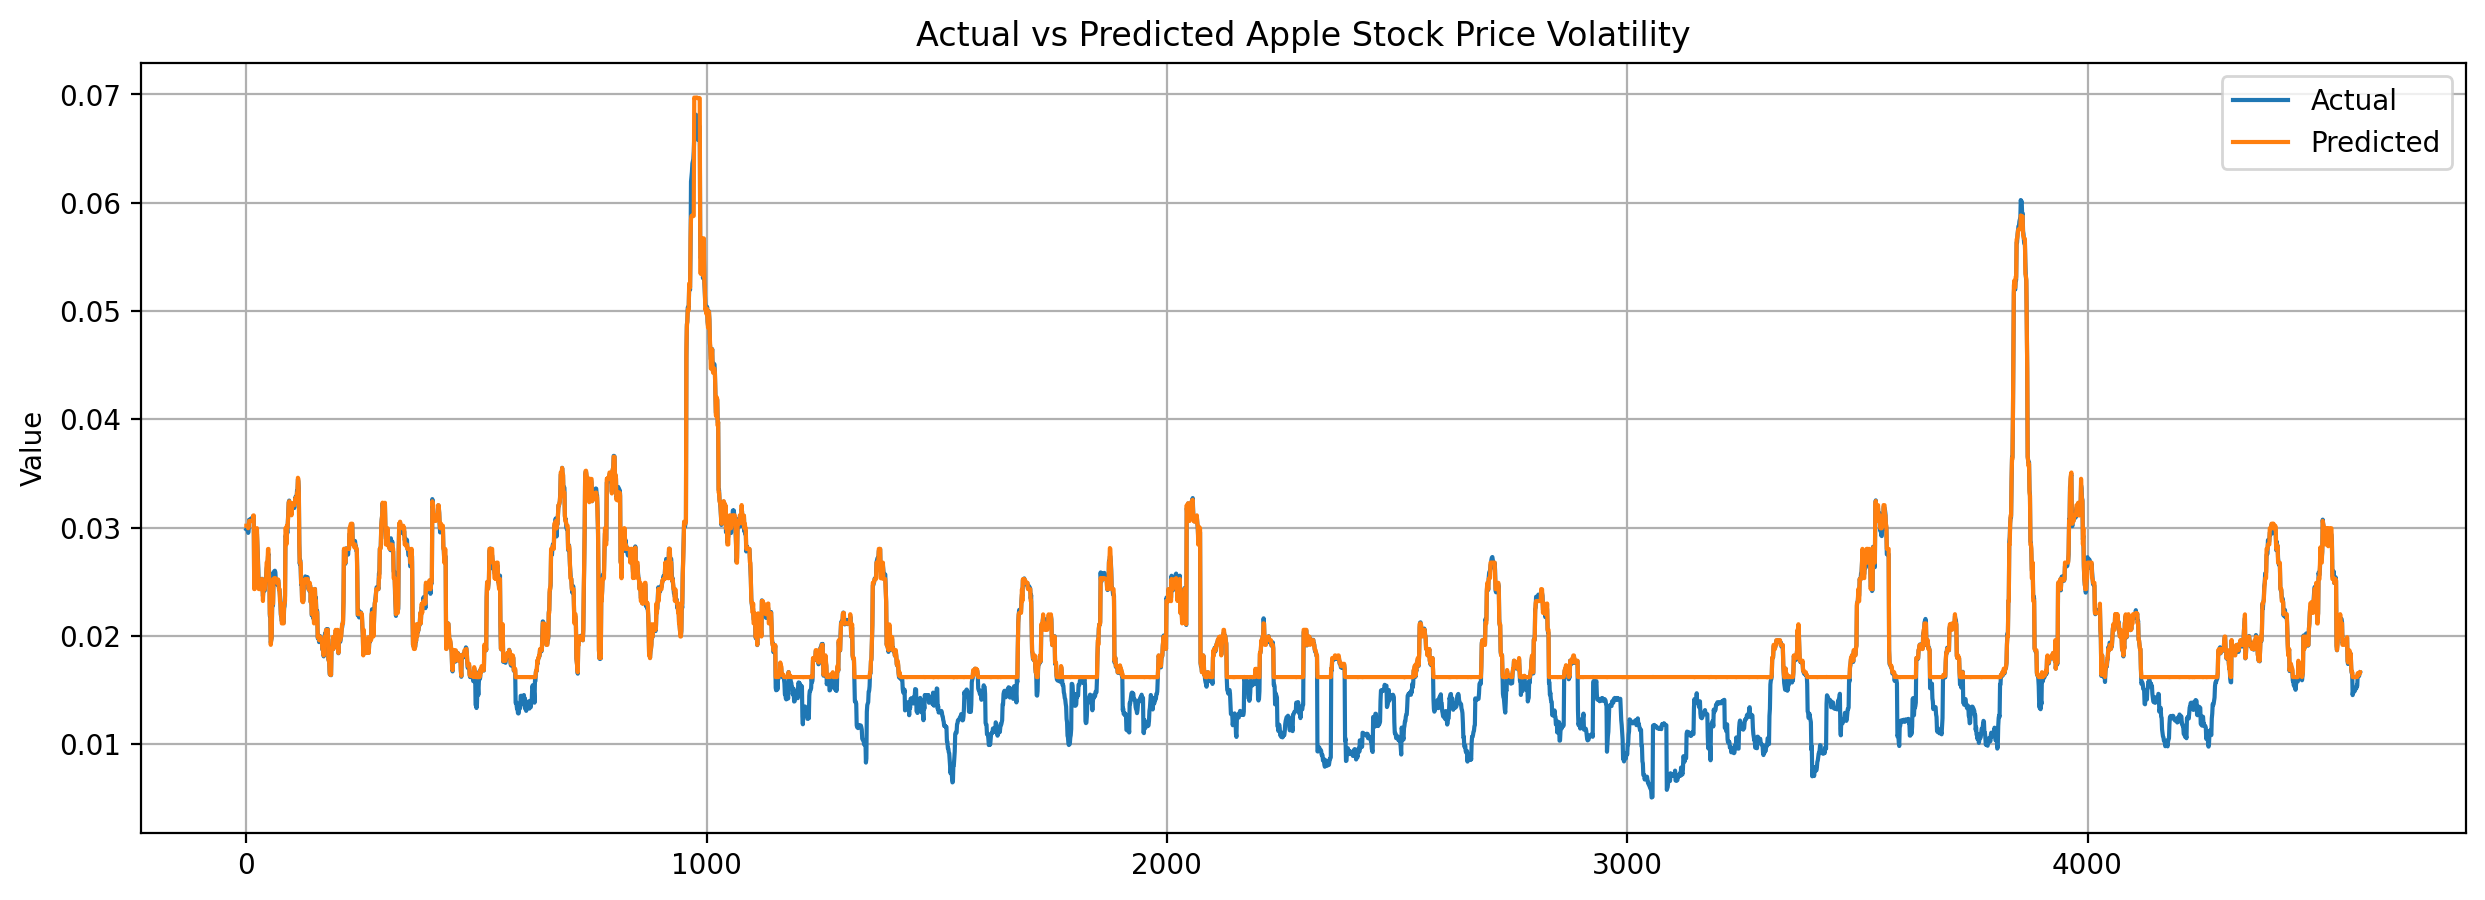

In [17]:
#storing the results in a dataframe
result =  pd.DataFrame([y_test.flatten(),y_pred])
result = result.T
result.columns = ['Actual','Predicted']

# illustrate the data
plt.figure(figsize=(15,5), dpi=200)
for i,c in enumerate(result.columns):
    result[c].plot(ax=plt.gca()); 
plt.legend()
plt.grid()
plt.ylabel('Value')
plt.title('Actual vs Predicted Apple Stock Price Volatility')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

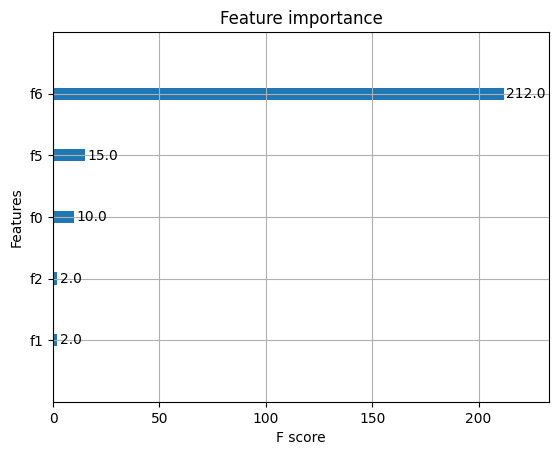

In [18]:
xgb.plot_importance(grid.best_estimator_)